In [ ]:
!pip install segmentation-models-pytorch

In [2]:
import os
import cv2
import glob 
# used to find all the pathnames matching a specified pattern
import PIL
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import montage 
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize
from PIL import Image, ImageOps  

# neural imaging
import nilearn as nl
import nibabel as nib
import nilearn.plotting as nlplt


# # ml libs
# import keras
# import keras.backend as K
# from keras.callbacks import CSVLogger
# import tensorflow as tf
# from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
# from tensorflow.keras.models import *
# from tensorflow.keras.layers import *
# from tensorflow.keras.optimizers import *
# from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
# from tensorflow.keras.layers.experimental import preprocessing
import torch
import torch.nn as nn
import torch.optim as optim
import segmentation_models_pytorch as smp
from transformers import AutoModel
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [3]:
# DEFINE seg-areas  
SEGMENT_CLASSES = {
    0 : 'NOT tumor',   
    1 : 'NECROTIC/CORE', # or NON-ENHANCING tumor CORE - RED
    2 : 'EDEMA',  # Green
    3 : 'ENHANCING' # original 4 -> converted into 3 later, Yellow
}

# there are 155 slices per volume
# to start at 5 and use 145 slices means we will skip the first 5 and last 5 
VOLUME_SLICES = 100 
VOLUME_START_AT = 22 # first slice of volume that we will include

IMG_SIZE=128

In [4]:
import tarfile
file = tarfile.open('../input/brats-2021-task1/BraTS2021_Training_Data.tar')

file.extractall('./BraTS2021_Training_Data')
file.close()

In [5]:
TRAIN_DATASET_PATH = './BraTS2021_Training_Data/'

In [ ]:
# import os
# import random
# import nibabel as nib
# import numpy as np
# from skimage.transform import resize
# from skimage import exposure
# from scipy.ndimage import rotate, gaussian_filter, map_coordinates
# import matplotlib.pyplot as plt
# import imageio
# from tqdm import tqdm


# def load_nifti(file_path):
#     return nib.load(file_path)

# def save_nifti(img, save_path):
#     nib.save(img, save_path)

# def resize_nifti(img, target_shape=(256, 256, 128)):
#     data = img.get_fdata()
#     data_resized = resize(data, target_shape, anti_aliasing=True)
#     return nib.Nifti1Image(data_resized, img.affine)

# def crop_brain_region(img, threshold=0.1):
#     data = img.get_fdata()
#     mask = data > (threshold * np.max(data))
#     coords = np.array(np.nonzero(mask))
#     min_coords = np.min(coords, axis=1)
#     max_coords = np.max(coords, axis=1)
#     cropped_data = data[min_coords[0]:max_coords[0], 
#                        min_coords[1]:max_coords[1], 
#                        min_coords[2]:max_coords[2]]
#     return nib.Nifti1Image(cropped_data, img.affine)

# def contrast_enhance_nifti(img):
#     data = img.get_fdata()
#     data_enhanced = exposure.equalize_hist(data)
#     return nib.Nifti1Image(data_enhanced, img.affine)

# def augment_nifti(img):
#     data = img.get_fdata()
#     data_rotated = rotate(data, angle=15, axes=(0, 1), reshape=False)
#     alpha, sigma = 50, 5
#     random_state = np.random.RandomState(None)
#     shape = data.shape
#     dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
#     dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
#     dz = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
#     x, y, z = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]), np.arange(shape[2]))
#     indices = np.reshape(x + dx, (-1, 1)), np.reshape(y + dy, (-1, 1)), np.reshape(z + dz, (-1, 1))
#     data_deformed = map_coordinates(data, indices, order=1, mode='reflect').reshape(shape)
#     return nib.Nifti1Image(data_deformed, img.affine)

# def plot_mri_slices(img, title, save_path):
#     data = img.get_fdata()
#     fig, axes = plt.subplots(1, 3, figsize=(12, 4))
#     for i, axis in enumerate([0, 1, 2]):
#         mid_slice = data.shape[axis] // 2
#         if axis == 0:
#             axes[i].imshow(data[mid_slice, :, :], cmap='gray')
#         elif axis == 1:
#             axes[i].imshow(data[:, mid_slice, :], cmap='gray')
#         else:
#             axes[i].imshow(data[:, :, mid_slice], cmap='gray')
#         axes[i].set_title(f'Slice {mid_slice} (axis {axis})')
#     plt.suptitle(title)
#     plt.show()
#     plt.savefig(save_path)
#     plt.close()

# def process_single_file(input_file, output_file, modality , count):
#     """Process a single NIFTI file based on its modality."""
#     try:
        
#         img = load_nifti(input_file)
#         if count == 3:
#             plot_mri_slices(img, 'Original MRI', output_file.replace('.nii.gz', '_original.png'))
        
#         if modality != 'seg':
#             img = crop_brain_region(img)
#             img = contrast_enhance_nifti(img)
#             img = resize_nifti(img)
#             img = augment_nifti(img)
        
#         save_nifti(img, output_file)
#         if count == 3:
#             plot_mri_slices(img, 'Processed MRI', output_file.replace('.nii.gz', '_processed.png'))
            
        
#     except Exception as e:
#         print(f"Error processing {input_file}: {str(e)}")
#         return False
    
#     return True

# def process_brats_dataset(input_root, output_root , count):
#     """Process the entire BraTS dataset maintaining exact file structure."""
#     os.makedirs(output_root, exist_ok=True)
    
#     all_files = [os.path.join(root, f) for root, _, files in os.walk(input_root) for f in files if f.endswith('.nii.gz')]
    
#     for file_path in tqdm(all_files, desc="Processing files"):
#         rel_path = os.path.relpath(file_path, input_root)
#         output_path = os.path.join(output_root, rel_path)
#         os.makedirs(os.path.dirname(output_path), exist_ok=True)
        
#         modality = None
#         if '_t1.' in file_path.lower() or '_t1.nii.gz' in file_path.lower():
#             modality = 't1'
#         elif '_t1ce.' in file_path.lower() or '_t1ce.nii.gz' in file_path.lower():
#             modality = 't1ce'
#         elif '_t2.' in file_path.lower() or '_t2.nii.gz' in file_path.lower():
#             modality = 't2'
#         elif '_flair.' in file_path.lower() or '_flair.nii.gz' in file_path.lower():
#             modality = 'flair'
#         elif '_seg.' in file_path.lower() or '_seg.nii.gz' in file_path.lower():
#             modality = 'seg'
        
#         if modality:
#             success = process_single_file(file_path, output_path, modality , count)
#             count=count+1
#             if not success:
#                 print(f"Failed to process {file_path}")

# def verify_preprocessing(input_root, output_root):
#     """Verify that all files were processed and maintained structure."""
#     input_files = {os.path.relpath(os.path.join(root, file), input_root) for root, _, files in os.walk(input_root) for file in files if file.endswith('.nii.gz')}
#     output_files = {os.path.relpath(os.path.join(root, file), output_root) for root, _, files in os.walk(output_root) for file in files if file.endswith('.nii.gz')}
    
#     missing_files = input_files - output_files
#     if missing_files:
#         print("\nWarning: Some files were not processed:")
#         for file in missing_files:
#             print(f"Missing: {file}")
#     else:
#         print("\nAll files were processed successfully!")

# if __name__ == "__main__":
#     count = 0 
#     BRATS_ROOT = '/kaggle/working/BraTS2021_Training_Data'  
#     OUTPUT_ROOT = './preprocessed_brats_data'  
    
#     print("Starting preprocessing...")
#     process_brats_dataset(BRATS_ROOT, OUTPUT_ROOT , count)
    
#     print("\nVerifying preprocessing...")
#     verify_preprocessing(BRATS_ROOT, OUTPUT_ROOT)

In [ ]:
import os
import random
import nibabel as nib
import numpy as np
from skimage.transform import resize
from skimage import exposure
from scipy.ndimage import rotate, gaussian_filter, map_coordinates
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import cv2

# Constants for preprocessing
TARGET_SHAPE = (128, 128, 128)  # Target shape for resampling
PATCH_SIZE = (128, 128)  # Patch size for extraction

def load_nifti(file_path):
    """Load a NIfTI file and return the image object."""
    return nib.load(file_path)

def save_nifti(data, affine, save_path):
    """Save data as a NIfTI file."""
    nib.save(nib.Nifti1Image(data, affine), save_path)

def resample_volume(img, target_shape=TARGET_SHAPE):
    """Resample volume to a uniform resolution of 1×1×1 mm."""
    data = img.get_fdata()
    original_shape = data.shape
    
    # Calculate resampling factors
    scale_factors = [t/o for t, o in zip(target_shape, original_shape)]
    
    # Resample data to target shape
    data_resampled = resize(data, target_shape, order=3, anti_aliasing=True, mode='constant')
    
    # Create new affine for 1x1x1 mm spacing
    new_affine = img.affine.copy()
    for i in range(3):
        new_affine[i, i] = img.affine[i, i] / scale_factors[i]
    
    return nib.Nifti1Image(data_resampled, new_affine)

def skull_strip(img, threshold=0.05):
    """Remove non-brain regions using intensity-based thresholding."""
    data = img.get_fdata()
    
    # Create mask based on threshold
    mask = data > (threshold * np.max(data))
    
    # Apply mask
    data_stripped = data * mask
    
    # Find bounding box coordinates
    coords = np.array(np.nonzero(mask))
    min_coords = np.min(coords, axis=1)
    max_coords = np.max(coords, axis=1)
    
    # Crop to bounding box
    cropped_data = data_stripped[
        min_coords[0]:max_coords[0]+1, 
        min_coords[1]:max_coords[1]+1, 
        min_coords[2]:max_coords[2]+1
    ]
    
    # Adjust affine for cropped region
    new_affine = img.affine.copy()
    new_affine[:3, 3] = img.affine[:3, 3] + img.affine[:3, :3] @ min_coords
    
    return nib.Nifti1Image(cropped_data, new_affine)

def intensity_normalization(img):
    """Standardize intensity values to z-scores within brain region."""
    data = img.get_fdata()
    mask = data > 0  # Brain mask
    
    if np.sum(mask) > 0:  # Ensure we have brain voxels
        # Calculate mean and std of brain region
        mean = np.mean(data[mask])
        std = np.std(data[mask])
        
        if std > 0:  # Avoid division by zero
            # Z-score normalization
            data_norm = np.zeros_like(data)
            data_norm[mask] = (data[mask] - mean) / std
        else:
            data_norm = data - mean  # If std=0, just subtract mean
    else:
        data_norm = data
        
    return nib.Nifti1Image(data_norm, img.affine)

def histogram_equalization(img):
    """Apply histogram equalization to enhance contrast."""
    data = img.get_fdata()
    mask = data > 0  # Only process brain voxels
    
    if np.sum(mask) > 0:
        # Get brain voxels
        brain_voxels = data[mask]
        
        # Apply histogram equalization
        p2, p98 = np.percentile(brain_voxels, (2, 98))
        brain_voxels_eq = exposure.rescale_intensity(brain_voxels, in_range=(p2, p98))
        
        # Put equalized values back
        data_eq = np.zeros_like(data)
        data_eq[mask] = brain_voxels_eq
        
        return nib.Nifti1Image(data_eq, img.affine)
    
    return img

def extract_patches(data, patch_size=PATCH_SIZE, overlap=0.25):
    """Extract 2D patches from 3D volume with overlap."""
    depth, height, width = data.shape
    patch_h, patch_w = patch_size
    
    # Calculate stride with overlap
    stride_h = int(patch_h * (1 - overlap))
    stride_w = int(patch_w * (1 - overlap))
    
    patches = []
    patch_coords = []
    
    # Extract patches from each slice
    for z in range(depth):
        for y in range(0, height - patch_h + 1, stride_h):
            for x in range(0, width - patch_w + 1, stride_w):
                patch = data[z, y:y+patch_h, x:x+patch_w]
                patches.append(patch)
                patch_coords.append((z, y, x))
    
    return patches, patch_coords

def data_augmentation(img, random_state=None):
    """Apply multiple data augmentation techniques."""
    if random_state is None:
        random_state = np.random.RandomState(None)
        
    data = img.get_fdata()
    augmented_data = data.copy()
    
    # Random rotation
    if random_state.rand() > 0.5:
        angle = random_state.uniform(-15, 15)
        axes = random_state.choice([(0, 1), (0, 2), (1, 2)])
        augmented_data = rotate(augmented_data, angle=angle, axes=axes, reshape=False, mode='constant')
    
    # Random elastic deformation
    if random_state.rand() > 0.5:
        shape = augmented_data.shape
        alpha = random_state.uniform(30, 70)  # Controls deformation strength
        sigma = random_state.uniform(4, 8)    # Controls smoothness
        
        # Generate displacement fields
        dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
        dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
        dz = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
        
        # Create mesh grid and apply deformation
        x, y, z = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]), np.arange(shape[2]), indexing='ij')
        indices = (x + dx).reshape(-1), (y + dy).reshape(-1), (z + dz).reshape(-1)
        augmented_data = map_coordinates(augmented_data, indices, order=1, mode='reflect').reshape(shape)
    
    # Random intensity scaling
    if random_state.rand() > 0.5:
        scale_factor = random_state.uniform(0.9, 1.1)
        augmented_data = augmented_data * scale_factor
    
    # Random gamma correction
    if random_state.rand() > 0.5:
        gamma = random_state.uniform(0.8, 1.2)
        augmented_data = np.power(augmented_data, gamma)
    
    return nib.Nifti1Image(augmented_data, img.affine)

def visualize_preprocessing(original_img, processed_img, title, save_path):
    """Create a visualization of original vs processed images across all axes."""
    original_data = original_img.get_fdata()
    processed_data = processed_img.get_fdata()
    
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    for i, axis in enumerate([0, 1, 2]):
        # Middle slice for each axis
        mid_slice = original_data.shape[axis] // 2
        
        # Original image
        if axis == 0:
            axes[0, i].imshow(original_data[mid_slice, :, :], cmap='gray')
            axes[1, i].imshow(processed_data[mid_slice, :, :], cmap='gray')
        elif axis == 1:
            axes[0, i].imshow(original_data[:, mid_slice, :], cmap='gray')
            axes[1, i].imshow(processed_data[:, mid_slice, :], cmap='gray')
        else:
            axes[0, i].imshow(original_data[:, :, mid_slice], cmap='gray')
            axes[1, i].imshow(processed_data[:, :, mid_slice], cmap='gray')
        
        axes[0, i].set_title(f'Original - Axis {axis}')
        axes[1, i].set_title(f'Processed - Axis {axis}')
        
        # Turn off axis ticks
        axes[0, i].set_xticks([])
        axes[0, i].set_yticks([])
        axes[1, i].set_xticks([])
        axes[1, i].set_yticks([])
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.close()

def process_single_file(input_file, output_file, modality=None, save_visualization=False, vis_sample_idx=None):
    """Process a single MRI file based on the paper's methodology."""
    try:
        print(f"Processing {input_file}...")
        img = load_nifti(input_file)
        original_img = img  # Save original for visualization
        
        # Only process imaging data (not segmentation maps)
        if modality != 'seg':
            # 1. Resampling
            img = resample_volume(img)
            
            # 2. Skull stripping (not applied to segmentation masks)
            img = skull_strip(img)
            
            # 3. Intensity normalization
            img = intensity_normalization(img)
            
            # 4. Contrast enhancement
            img = histogram_equalization(img)
            
            # 5. (Optional) Data augmentation - only applied if specified
            if os.environ.get('AUGMENT_DATA', 'False').lower() == 'true':
                img = data_augmentation(img)
        else:
            # For segmentation masks, just resample to match image dimensions
            img = resample_volume(img)
            
        # Save the processed file
        save_nifti(img.get_fdata(), img.affine, output_file)
        
        # Create visualization if requested and this is a sample case
        if save_visualization and vis_sample_idx is not None:
            os.makedirs(os.path.dirname(output_file), exist_ok=True)
            vis_path = output_file.replace('.nii.gz', f'_visualization_{modality}.png')
            visualize_preprocessing(original_img, img, f'BraTS - {modality.upper()} - Case {vis_sample_idx}', vis_path)
            
        return True
        
    except Exception as e:
        print(f"Error processing {input_file}: {str(e)}")
        return False

def process_brats_dataset(input_root, output_root, num_visualization_samples=5):
    """Process the entire BraTS dataset according to paper's methodology."""
    os.makedirs(output_root, exist_ok=True)
    
    # Collect all .nii.gz files
    all_files = []
    for root, _, files in os.walk(input_root):
        for f in files:
            if f.endswith('.nii.gz'):
                all_files.append(os.path.join(root, f))
    
    # Group files by patient
    patient_files = {}
    for file_path in all_files:
        # Extract patient ID
        rel_path = os.path.relpath(file_path, input_root)
        parts = rel_path.split(os.sep)
        patient_id = parts[0]  # Assuming first folder is patient ID
        
        if patient_id not in patient_files:
            patient_files[patient_id] = []
        
        patient_files[patient_id].append(file_path)
    
    # Randomly select patients for visualization
    all_patients = list(patient_files.keys())
    vis_patients = random.sample(all_patients, min(num_visualization_samples, len(all_patients)))
    
    # Process all files
    total_success = 0
    total_failed = 0
    
    for patient_idx, patient_id in enumerate(tqdm(all_patients, desc="Processing patients")):
        for file_path in patient_files[patient_id]:
            rel_path = os.path.relpath(file_path, input_root)
            output_path = os.path.join(output_root, rel_path)
            os.makedirs(os.path.dirname(output_path), exist_ok=True)
            
            # Determine modality
            modality = None
            if '_t1.' in file_path.lower() or '_t1_' in file_path.lower():
                modality = 't1'
            elif '_t1ce.' in file_path.lower() or '_t1ce_' in file_path.lower():
                modality = 't1ce'
            elif '_t2.' in file_path.lower() or '_t2_' in file_path.lower():
                modality = 't2'
            elif '_flair.' in file_path.lower() or '_flair_' in file_path.lower():
                modality = 'flair'
            elif '_seg.' in file_path.lower() or '_seg_' in file_path.lower():
                modality = 'seg'
            
            # Save visualization for selected patients
            save_vis = patient_id in vis_patients
            vis_idx = vis_patients.index(patient_id) if save_vis else None
            
            if modality:
                success = process_single_file(file_path, output_path, modality, save_vis, vis_idx)
                if success:
                    total_success += 1
                else:
                    total_failed += 1
                    print(f"Failed to process {file_path}")
    
    print(f"\nProcessing completed: {total_success} files processed successfully, {total_failed} files failed.")

def generate_metadata_csv(input_root, output_csv):
    """Generate a CSV with metadata about all processed files."""
    metadata = []
    
    for root, _, files in os.walk(input_root):
        for f in files:
            if f.endswith('.nii.gz'):
                file_path = os.path.join(root, f)
                rel_path = os.path.relpath(file_path, input_root)
                
                # Determine modality
                modality = None
                if '_t1.' in f.lower() or '_t1_' in f.lower():
                    modality = 't1'
                elif '_t1ce.' in f.lower() or '_t1ce_' in f.lower():
                    modality = 't1ce'
                elif '_t2.' in f.lower() or '_t2_' in f.lower():
                    modality = 't2'
                elif '_flair.' in f.lower() or '_flair_' in f.lower():
                    modality = 'flair'
                elif '_seg.' in f.lower() or '_seg_' in f.lower():
                    modality = 'seg'
                
                try:
                    # Load image to get shape and other metadata
                    img = load_nifti(file_path)
                    data = img.get_fdata()
                    
                    # Calculate statistics for non-zero values (brain tissue)
                    non_zero = data[data > 0]
                    if len(non_zero) > 0:
                        mean_intensity = np.mean(non_zero)
                        std_intensity = np.std(non_zero)
                        min_intensity = np.min(non_zero)
                        max_intensity = np.max(non_zero)
                    else:
                        mean_intensity = std_intensity = min_intensity = max_intensity = 0
                    
                    # Get patient ID from directory structure
                    parts = rel_path.split(os.sep)
                    patient_id = parts[0]  # Assuming first folder is patient ID
                    
                    metadata.append({
                        'file_path': rel_path,
                        'patient_id': patient_id,
                        'modality': modality,
                        'shape_x': data.shape[0],
                        'shape_y': data.shape[1],
                        'shape_z': data.shape[2],
                        'mean_intensity': mean_intensity,
                        'std_intensity': std_intensity,
                        'min_intensity': min_intensity,
                        'max_intensity': max_intensity,
                        'voxel_count': data.size,
                        'non_zero_voxel_count': len(non_zero)
                    })
                except Exception as e:
                    print(f"Error extracting metadata for {file_path}: {str(e)}")
    
    # Create DataFrame and save to CSV
    df = pd.DataFrame(metadata)
    df.to_csv(output_csv, index=False)
    print(f"Metadata saved to {output_csv}")

def visualize_dataset_statistics(metadata_csv, output_dir):
    """Generate visualizations of dataset statistics."""
    os.makedirs(output_dir, exist_ok=True)
    df = pd.read_csv(metadata_csv)
    
    # 1. Distribution of intensities by modality
    plt.figure(figsize=(12, 8))
    modalities = ['t1', 't1ce', 't2', 'flair']
    for modality in modalities:
        data = df[df['modality'] == modality]['mean_intensity']
        if not data.empty:
            plt.hist(data, bins=50, alpha=0.5, label=modality)
    plt.title('Distribution of Mean Intensities by Modality')
    plt.xlabel('Mean Intensity')
    plt.ylabel('Frequency')
    plt.legend()
    plt.savefig(os.path.join(output_dir, 'intensity_distribution.png'), dpi=300, bbox_inches='tight')
    plt.close()
    
    # 2. Volume statistics
    plt.figure(figsize=(12, 8))
    df['volume'] = df['non_zero_voxel_count'] / (df['shape_x'] * df['shape_y'] * df['shape_z'])
    
    for modality in modalities:
        data = df[df['modality'] == modality]['volume']
        if not data.empty:
            plt.hist(data, bins=50, alpha=0.5, label=modality)
    plt.title('Distribution of Brain Volume Ratios by Modality')
    plt.xlabel('Volume Ratio (non-zero voxels / total voxels)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.savefig(os.path.join(output_dir, 'volume_distribution.png'), dpi=300, bbox_inches='tight')
    plt.close()
    
    # 3. Box plots of intensity statistics
    plt.figure(figsize=(15, 8))
    df_subset = df[df['modality'].isin(modalities)]
    
    plt.subplot(1, 2, 1)
    sns_plot = sns.boxplot(x='modality', y='mean_intensity', data=df_subset)
    plt.title('Mean Intensity by Modality')
    
    plt.subplot(1, 2, 2)
    sns_plot = sns.boxplot(x='modality', y='std_intensity', data=df_subset)
    plt.title('Intensity Standard Deviation by Modality')
    
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, 'intensity_boxplots.png'), dpi=300, bbox_inches='tight')
    plt.close()

def create_patch_dataset(input_root, output_dir, patch_size=PATCH_SIZE, samples_per_patient=10):
    """Extract 2D patches from processed images and save as PNG files."""
    os.makedirs(output_dir, exist_ok=True)
    
    # Group files by patient
    patient_files = {}
    for root, _, files in os.walk(input_root):
        for f in files:
            if f.endswith('.nii.gz'):
                file_path = os.path.join(root, f)
                rel_path = os.path.relpath(file_path, input_root)
                parts = rel_path.split(os.sep)
                patient_id = parts[0]
                
                if patient_id not in patient_files:
                    patient_files[patient_id] = []
                
                patient_files[patient_id].append((file_path, rel_path))
    
    # Process each patient
    for patient_id, files in tqdm(patient_files.items(), desc="Extracting patches"):
        # Create directories for each modality
        for modality in ['t1', 't1ce', 't2', 'flair', 'seg']:
            os.makedirs(os.path.join(output_dir, modality), exist_ok=True)
        
        # Process each file for the patient
        patient_data = {}
        for file_path, rel_path in files:
            # Determine modality
            modality = None
            if '_t1.' in file_path.lower() or '_t1_' in file_path.lower():
                modality = 't1'
            elif '_t1ce.' in file_path.lower() or '_t1ce_' in file_path.lower():
                modality = 't1ce'
            elif '_t2.' in file_path.lower() or '_t2_' in file_path.lower():
                modality = 't2'
            elif '_flair.' in file_path.lower() or '_flair_' in file_path.lower():
                modality = 'flair'
            elif '_seg.' in file_path.lower() or '_seg_' in file_path.lower():
                modality = 'seg'
            
            if modality:
                try:
                    img = load_nifti(file_path)
                    patient_data[modality] = img.get_fdata()
                except Exception as e:
                    print(f"Error loading {file_path}: {str(e)}")
        
        # Only proceed if we have all modalities
        required_modalities = ['t1', 't1ce', 't2', 'flair', 'seg']
        if all(m in patient_data for m in required_modalities):
            # Find slices with tumor (non-zero segmentation)
            tumor_slices = []
            for z in range(patient_data['seg'].shape[0]):
                if np.any(patient_data['seg'][z, :, :] > 0):
                    tumor_slices.append(z)
            
            # Select random slices (prioritizing tumor slices)
            if tumor_slices:
                selected_slices = random.sample(tumor_slices, min(samples_per_patient, len(tumor_slices)))
                # If we need more slices, add random non-tumor slices
                if len(selected_slices) < samples_per_patient:
                    non_tumor_slices = [z for z in range(patient_data['seg'].shape[0]) if z not in tumor_slices]
                    if non_tumor_slices:
                        more_slices = random.sample(non_tumor_slices, min(samples_per_patient - len(selected_slices), len(non_tumor_slices)))
                        selected_slices.extend(more_slices)
            else:
                # If no tumor slices, just pick random slices
                all_slices = list(range(patient_data['seg'].shape[0]))
                selected_slices = random.sample(all_slices, min(samples_per_patient, len(all_slices)))
            
            # Extract and save patches for selected slices
            for slice_idx in selected_slices:
                for modality in required_modalities:
                    slice_data = patient_data[modality][slice_idx, :, :]
                    
                    # Normalize for visualization (except segmentation)
                    if modality != 'seg':
                        non_zero = slice_data[slice_data > 0]
                        if len(non_zero) > 0:
                            p2, p98 = np.percentile(non_zero, (2, 98))
                            slice_data = exposure.rescale_intensity(slice_data, in_range=(p2, p98), out_range=(0, 255))
                    else:
                        # For segmentation, just scale to 0-255
                        if np.max(slice_data) > 0:
                            slice_data = (slice_data / np.max(slice_data) * 255).astype(np.uint8)
                    
                    # Save as PNG
                    output_file = os.path.join(output_dir, modality, f"{patient_id}_slice{slice_idx}.png")
                    cv2.imwrite(output_file, slice_data.astype(np.uint8))

def main():
    """Main function to run the preprocessing pipeline."""
    import argparse
    
    parser = argparse.ArgumentParser(description='MRI Brain Tumor Preprocessing Pipeline')
    parser.add_argument('--input', required=True, help='Input directory containing BraTS dataset')
    parser.add_argument('--output', required=True, help='Output directory for processed files')
    parser.add_argument('--visualize', action='store_true', help='Generate visualization samples')
    parser.add_argument('--metadata', action='store_true', help='Generate metadata CSV')
    parser.add_argument('--patches', action='store_true', help='Extract 2D patches from processed data')
    parser.add_argument('--augment', action='store_true', help='Apply data augmentation')
    
    args = parser.parse_args()
    
    # Set environment variable for augmentation
    if args.augment:
        os.environ['AUGMENT_DATA'] = 'True'
    
    # Create output directory
    os.makedirs(args.output, exist_ok=True)
    
    # Process the BraTS dataset
    process_brats_dataset(args.input, args.output, num_visualization_samples=5 if args.visualize else 0)
    
    # Generate metadata if requested
    if args.metadata:
        metadata_csv = os.path.join(args.output, 'dataset_metadata.csv')
        generate_metadata_csv(args.output, metadata_csv)
        
        # Generate visualizations of dataset statistics
        stats_dir = os.path.join(args.output, 'statistics')
        visualize_dataset_statistics(metadata_csv, stats_dir)
    
    # Extract patches if requested
    if args.patches:
        patches_dir = os.path.join(args.output, 'patches')
        create_patch_dataset(args.output, patches_dir, samples_per_patient=10)

if __name__ == "__main__":
    # Handle import error for seaborn (used in visualization)
    try:
        import seaborn as sns
    except ImportError:
        print("Warning: seaborn not installed. Some visualizations may not work.")
        # Define a simple replacement for sns.boxplot
        def boxplot(*args, **kwargs):
            data = kwargs.get('data')
            x = kwargs.get('x')
            y = kwargs.get('y')
            if data is not None and x is not None and y is not None:
                groups = data.groupby(x)[y].apply(list)
                plt.boxplot(groups.values)
                plt.xticks(range(1, len(groups) + 1), groups.index)
            return plt.gca()
        
        # Create mock sns module
        class MockSNS:
            def boxplot(self, *args, **kwargs):
                return boxplot(*args, **kwargs)
        
        sns = MockSNS()
    
    main()

In [6]:
import torch

def dice_coef(y_true, y_pred, smooth=1.0):
    """
    Calculate average Dice coefficient across all classes
    Args:
        y_true: ground truth masks
        y_pred: predicted masks
        smooth: smoothing factor
    Returns:
        mean Dice coefficient across all classes
    """
    class_num = 4  # Number of classes
    dice_list = []
    
    for i in range(class_num):
        # Reshape the tensors into 1D arrays for each class
        y_true_f = y_true[:, i].reshape(-1)
        y_pred_f = y_pred[:, i].reshape(-1)
        
        # Compute intersection and Dice coefficient
        intersection = torch.sum(y_true_f * y_pred_f)
        union = torch.sum(y_true_f) + torch.sum(y_pred_f)
        dice = (2. * intersection + smooth) / (union + smooth)
        dice_list.append(dice)

    return torch.mean(torch.stack(dice_list))

def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    """Calculate Dice coefficient for necrotic tumor core (label 1)"""
    intersection = torch.sum(torch.abs(y_true[:, 1] * y_pred[:, 1]))
    union = torch.sum(torch.square(y_true[:, 1])) + torch.sum(torch.square(y_pred[:, 1]))
    return (2. * intersection) / (union + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    """Calculate Dice coefficient for peritumoral edema (label 2)"""
    intersection = torch.sum(torch.abs(y_true[:, 2] * y_pred[:, 2]))
    union = torch.sum(torch.square(y_true[:, 2])) + torch.sum(torch.square(y_pred[:, 2]))
    return (2. * intersection) / (union + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    """Calculate Dice coefficient for enhancing tumor (label 3)"""
    intersection = torch.sum(torch.abs(y_true[:, 3] * y_pred[:, 3]))
    union = torch.sum(torch.square(y_true[:, 3])) + torch.sum(torch.square(y_pred[:, 3]))
    return (2. * intersection) / (union + epsilon)

def precision(y_true, y_pred):
    """
    Calculate precision
    """
    true_positives = torch.sum(torch.round(torch.clamp(y_true * y_pred, 0, 1)))
    predicted_positives = torch.sum(torch.round(torch.clamp(y_pred, 0, 1)))
    return true_positives / (predicted_positives + torch.finfo(torch.float32).eps)

def sensitivity(y_true, y_pred):
    """
    Calculate sensitivity (recall)
    """
    true_positives = torch.sum(torch.round(torch.clamp(y_true * y_pred, 0, 1)))
    possible_positives = torch.sum(torch.round(torch.clamp(y_true, 0, 1)))
    return true_positives / (possible_positives + torch.finfo(torch.float32).eps)

def specificity(y_true, y_pred):
    """
    Calculate specificity
    """
    true_negatives = torch.sum(torch.round(torch.clamp((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = torch.sum(torch.round(torch.clamp(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + torch.finfo(torch.float32).eps)

In [ ]:
# # Safe Dice coefficient to prevent NaN values
# def safe_dice_coef(y_true, y_pred, epsilon=1e-7):
#     # Clip predictions to prevent numerical instability
#     y_pred = torch.clamp(y_pred, epsilon, 1.0 - epsilon)
    
#     # Flatten the tensors
#     y_true_f = y_true.view(-1)
#     y_pred_f = y_pred.view(-1)
    
#     # Compute dice coefficient
#     intersection = torch.sum(y_true_f * y_pred_f)
    
#     # Use smooth factor for numerical stability
#     return (2. * intersection + epsilon) / (torch.sum(y_true_f) + torch.sum(y_pred_f) + epsilon)

# # Safe versions of each metric function (assuming these are your existing metric functions)
# def dice_coef(y_true, y_pred):
#     return safe_dice_coef(y_true, y_pred)

# def dice_coef_necrotic(y_true, y_pred):
#     # Assuming y_true and y_pred are multi-channel tensors and necrotic is first channel
#     # Adjust channel index as needed based on your data format
#     return safe_dice_coef(y_true[:, 0:1], y_pred[:, 0:1])

# def dice_coef_edema(y_true, y_pred):
#     # Assuming edema is second channel 
#     return safe_dice_coef(y_true[:, 1:2], y_pred[:, 1:2])

# def dice_coef_enhancing(y_true, y_pred):
#     # Assuming enhancing is third channel
#     return safe_dice_coef(y_true[:, 2:3], y_pred[:, 2:3])

# def precision(y_true, y_pred, epsilon=1e-7):
#     y_pred = torch.clamp(y_pred, epsilon, 1.0 - epsilon)
#     y_true_f = y_true.view(-1)
#     y_pred_f = y_pred.view(-1)
    
#     # True positives
#     true_positives = torch.sum(y_true_f * y_pred_f)
#     # All positives (true and false)
#     all_positives = torch.sum(y_pred_f)
    
#     return (true_positives + epsilon) / (all_positives + epsilon)

# def sensitivity(y_true, y_pred, epsilon=1e-7):
#     y_pred = torch.clamp(y_pred, epsilon, 1.0 - epsilon)
#     y_true_f = y_true.view(-1)
#     y_pred_f = y_pred.view(-1)
    
#     # True positives
#     true_positives = torch.sum(y_true_f * y_pred_f)
#     # All actual positives
#     actual_positives = torch.sum(y_true_f)
    
#     return (true_positives + epsilon) / (actual_positives + epsilon)

# def specificity(y_true, y_pred, epsilon=1e-7):
#     y_pred = torch.clamp(y_pred, epsilon, 1.0 - epsilon)
#     y_true_f = y_true.view(-1)
#     y_pred_f = y_pred.view(-1)
    
#     # True negatives
#     true_negatives = torch.sum((1 - y_true_f) * (1 - y_pred_f))
#     # All actual negatives
#     actual_negatives = torch.sum(1 - y_true_f)
    
#     return (true_negatives + epsilon) / (actual_negatives + epsilon)


In [7]:
# lists of directories with studies
train_and_val_directories = [f.path for f in os.scandir(TRAIN_DATASET_PATH) if f.is_dir()]

# file BraTS20_Training_355 has ill formatted name for for seg.nii file
#train_and_val_directories.remove(TRAIN_DATASET_PATH+'BraTS20_Training_355')


def pathListIntoIds(dirList):
    x = []
    for i in range(0,len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/')+1:])
    return x

train_and_test_ids = pathListIntoIds(train_and_val_directories); 

    
train_test_ids, val_ids = train_test_split(train_and_test_ids,test_size=0.2) 
train_ids, test_ids = train_test_split(train_test_ids,test_size=0.15) 

In [8]:
class BrainMRIDataset(Dataset):
    def __init__(self, list_IDs, img_size=240, n_channels=2, shuffle=True, 
                 volume_slices=155, volume_start_at=0, train_dataset_path=''):
        self.list_IDs = list_IDs
        self.dim = (img_size, img_size)
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.volume_slices = volume_slices
        self.volume_start_at = volume_start_at
        self.train_dataset_path = train_dataset_path
        self.indexes = np.arange(len(self.list_IDs) * self.volume_slices)
        
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __len__(self):
        'Total number of slices across all volumes'
        return len(self.list_IDs) * self.volume_slices

    def __getitem__(self, index):
        'Generate one slice of data'
        # Calculate which volume and slice to use
        volume_idx = index // self.volume_slices
        slice_idx = index % self.volume_slices + self.volume_start_at
        
        # Get the case ID
        case_id = self.list_IDs[volume_idx]
        case_path = os.path.join(self.train_dataset_path, case_id)

        # Load the specific slice from MRI images
        flair = nib.load(os.path.join(case_path, f'{case_id}_flair.nii.gz')).get_fdata()
        ce = nib.load(os.path.join(case_path, f'{case_id}_t1ce.nii.gz')).get_fdata()
        seg = nib.load(os.path.join(case_path, f'{case_id}_seg.nii.gz')).get_fdata()

        # Get the specific slice and resize
        X = np.zeros((*self.dim, self.n_channels), dtype=np.float32)
        X[:, :, 0] = cv2.resize(flair[:, :, slice_idx], self.dim)
        X[:, :, 1] = cv2.resize(ce[:, :, slice_idx], self.dim)
        
        # Process segmentation mask
        y = seg[:, :, slice_idx]
        y[y == 4] = 3  # Remap class 4 to 3
        
        # Convert to tensor and normalize
        X = torch.FloatTensor(X).permute(2, 0, 1)  # Change to (C, H, W)
        X = X / (torch.max(X) + 1e-8)
        
        # Convert mask to one-hot encoding
        y = torch.tensor(y, dtype=torch.long)
        Y = F.one_hot(y, num_classes=4).permute(2, 0, 1).float()  # (num_classes, H, W)
        Y = F.interpolate(Y.unsqueeze(0), size=self.dim, mode='nearest').squeeze(0)

        return X, Y

def get_data_loaders(train_ids, val_ids, test_ids, batch_size=16, **dataset_kwargs):
    """
    Create PyTorch DataLoaders for train, validation, and test sets
    """
    # Create datasets
    train_dataset = BrainMRIDataset(train_ids, **dataset_kwargs)
    val_dataset = BrainMRIDataset(val_ids, **dataset_kwargs)
    test_dataset = BrainMRIDataset(test_ids, **dataset_kwargs)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

    return train_loader, val_loader, test_loader

In [9]:
train_loader, val_loader, test_loader = get_data_loaders(
    train_ids=train_ids,
    val_ids=val_ids,
    test_ids=test_ids,
    batch_size=32,
    img_size=240,
    n_channels=2,
    volume_slices=100,
    volume_start_at=22,
    train_dataset_path=TRAIN_DATASET_PATH
)


In [ ]:
# def get_data_loaders(train_ids, val_ids, test_ids, batch_size=16, world_size=None, rank=None, **dataset_kwargs):
#     """
#     Create PyTorch DataLoaders optimized for GPU processing with distributed training support
    
#     Args:
#         train_ids: IDs for training set
#         val_ids: IDs for validation set
#         test_ids: IDs for test set
#         batch_size: Batch size per GPU
#         world_size: Number of GPUs (for distributed training)
#         rank: Current GPU rank (for distributed training)
#         **dataset_kwargs: Additional arguments for dataset creation
#     """
#     # Create datasets
#     train_dataset = BrainMRIDataset(train_ids, **dataset_kwargs)
#     val_dataset = BrainMRIDataset(val_ids, **dataset_kwargs)
#     test_dataset = BrainMRIDataset(test_ids, **dataset_kwargs)
    
#     # Set up for distributed training if applicable
#     train_sampler = None
#     val_sampler = None
#     test_sampler = None
    
#     if world_size is not None and rank is not None:
#         # Create distributed samplers for multi-GPU training
#         train_sampler = torch.utils.data.distributed.DistributedSampler(
#             train_dataset,
#             num_replicas=world_size,
#             rank=rank,
#             shuffle=True
#         )
        
#         val_sampler = torch.utils.data.distributed.DistributedSampler(
#             val_dataset,
#             num_replicas=world_size,
#             rank=rank,
#             shuffle=False
#         )
        
#         test_sampler = torch.utils.data.distributed.DistributedSampler(
#             test_dataset,
#             num_replicas=world_size,
#             rank=rank,
#             shuffle=False
#         )
        
#         # For distributed training, don't shuffle in dataloader as sampler handles it
#         shuffle = False
#     else:
#         # For single GPU, use regular shuffling
#         shuffle = True
    
#     # Performance optimizations for data loading
#     # Create data loaders with optimized parameters
#     train_loader = DataLoader(
#         train_dataset, 
#         batch_size=batch_size, 
#         shuffle=shuffle if train_sampler is None else False,
#         sampler=train_sampler,
#         num_workers=4,  # 4 workers per GPU is typically optimal
#         pin_memory=True,  # Faster data transfer to GPU
#         drop_last=True,  # Avoid smaller batches, helpful for BatchNorm
#         persistent_workers=True,  # Keep workers alive between epochs
#         prefetch_factor=2  # Prefetch 2 batches per worker for smoother processing
#     )
    
#     val_loader = DataLoader(
#         val_dataset, 
#         batch_size=batch_size, 
#         shuffle=False,
#         sampler=val_sampler,
#         num_workers=4, 
#         pin_memory=True,
#         persistent_workers=True,
#         prefetch_factor=2
#     )
    
#     test_loader = DataLoader(
#         test_dataset, 
#         batch_size=batch_size, 
#         shuffle=False,
#         sampler=test_sampler,
#         num_workers=4, 
#         pin_memory=True,
#         persistent_workers=True,
#         prefetch_factor=2
#     )
    
#     return train_loader, val_loader, test_loader


# # Example usage for multi-GPU training:
# def create_data_loaders_for_distributed(train_ids, val_ids, test_ids, batch_size, world_size, rank, **kwargs):
#     """Helper function to create data loaders for distributed training"""
#     return get_data_loaders(
#         train_ids=train_ids,
#         val_ids=val_ids,
#         test_ids=test_ids,
#         batch_size=batch_size,  # This will be the per-GPU batch size
#         world_size=world_size,
#         rank=rank,
#         **kwargs
#     )


# # Example usage for single-GPU training:
# def create_data_loaders_for_single_gpu(train_ids, val_ids, test_ids, batch_size, **kwargs):
#     """Helper function to create data loaders for single GPU training"""
#     return get_data_loaders(
#         train_ids=train_ids,
#         val_ids=val_ids,
#         test_ids=test_ids,
#         batch_size=batch_size,
#         **kwargs
#     )


# # # Use in your training script:
# # if __name__ == '__main__':
    
# #     # Set environment variables before initializing process group
# #     os.environ['RANK'] = '0'  # This process's rank
# #     os.environ['WORLD_SIZE'] = '1'  # Total number of processes
# #     os.environ['MASTER_ADDR'] = 'localhost'  # Address of the master process
# #     os.environ['MASTER_PORT'] = '29500'  # Port for communication
    
# #     world_size = torch.cuda.device_count()
# #     dist.init_process_group(backend='nccl')
# #     rank = dist.get_rank()
    
# #     # For single GPU usage
# #     # train_loader, val_loader, test_loader = create_data_loaders_for_single_gpu(
# #     #     train_ids=train_ids,
# #     #     val_ids=val_ids,
# #     #     test_ids=test_ids,
# #     #     batch_size=32,
# #     #     img_size=240,
# #     #     n_channels=2,
# #     #     volume_slices=100,
# #     #     volume_start_at=22,
# #     #     train_dataset_path=TRAIN_DATASET_PATH
# #     # )
    
# #     # For multi-GPU usage inside the train_ddp function
# #     train_loader, val_loader, test_loader = create_data_loaders_for_distributed(
# #         train_ids=train_ids,
# #         val_ids=val_ids,
# #         test_ids=test_ids,
# #         batch_size=16,  # 16 per GPU = 32 total across 2 GPUs
# #         world_size=world_size,
# #         rank=rank,
# #         img_size=240,
# #         n_channels=2,
# #         volume_slices=100,
# #         volume_start_at=22,
# #         train_dataset_path=TRAIN_DATASET_PATH
# #     )

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import segmentation_models_pytorch as smp
from transformers import AutoModel
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

class TransformerBlock(nn.Module):
    def __init__(self, transformer_name="huawei-noah/TinyBERT_General_4L_312D", embedding_dim=512):
        super().__init__()
        self.transformer_name = transformer_name
        self.embedding_dim = embedding_dim
        
        # Load transformer
        self.transformer = AutoModel.from_pretrained(transformer_name)
        self.transformer.eval()
        
        bert_hidden_size = self.transformer.config.hidden_size
        
        # Initial projection to match transformer dimensions
        self.input_projection = nn.Conv2d(embedding_dim, bert_hidden_size, 1)
        
        # Layer norms for each stage
        self.layer_norm1 = nn.LayerNorm(bert_hidden_size)
        self.layer_norm2 = nn.LayerNorm(bert_hidden_size)
        self.layer_norm3 = nn.LayerNorm(bert_hidden_size)
        
        # Dense layers
        self.intermediate_dense = nn.Linear(bert_hidden_size, bert_hidden_size)
        self.output_projection = nn.Conv2d(bert_hidden_size, embedding_dim, 1)
        
        self.pos_embedding = None
        self.register_buffer('initialized_pos_embedding', torch.tensor(0))

    def build(self, h, w):
        device = self.initialized_pos_embedding.device
        if self.pos_embedding is None:
            bert_hidden_size = self.transformer.config.hidden_size
            self.pos_embedding = nn.Parameter(
                torch.randn(1, h * w, bert_hidden_size, device=device) * 0.02
            )

    def forward(self, x):
        batch_size, c, h, w = x.shape
        device = x.device
        
        # Ensure transformer is on the same device
        if next(self.transformer.parameters()).device != device:
            self.transformer = self.transformer.to(device)
        
        # Initial projection to match transformer dimensions
        x = self.input_projection(x)  # B, transformer_dim, H, W
        
        # Reshape for transformer
        x = x.permute(0, 2, 3, 1)  # B, H, W, transformer_dim
        x = x.reshape(batch_size, h * w, -1)  # B, H*W, transformer_dim
        
        # Initialize position embeddings if needed
        self.build(h, w)
        
        # Add position embeddings and normalize
        x = x + self.pos_embedding.to(device)
        x = self.layer_norm1(x)
        
        # Create attention mask
        attention_mask = torch.ones((batch_size, h * w), dtype=torch.long, device=device)
        
        # Pass through transformer
        x = self.transformer(inputs_embeds=x, attention_mask=attention_mask)[0]
        
        # Process features
        x = self.layer_norm2(x)
        x = self.intermediate_dense(x)
        x = F.gelu(x)
        
        x = self.layer_norm3(x)
        
        # Reshape back to spatial dimensions
        x = x.reshape(batch_size, h, w, -1)
        x = x.permute(0, 3, 1, 2)  # B, C, H, W
        
        # Project back to original dimension
        x = self.output_projection(x)
        
        return x

class CustomUNetPlusPlusDecoder(nn.Module):
    """
    A custom UNet++ decoder that works with the spatial dimensions in your model.
    This is a simplified implementation that should handle the specific feature map sizes.
    """
    def __init__(self, encoder_channels, decoder_channels=(256, 128, 64, 32, 16)):
        super().__init__()
        self.encoder_channels = encoder_channels
        self.decoder_channels = decoder_channels
        
        # Create decoder blocks
        self.decoder_blocks = nn.ModuleList()
        
        # Build decoder blocks for each stage
        for i in range(len(decoder_channels)):
            # Calculate input channels for each block
            if i == 0:
                in_ch = encoder_channels[-1]
            else:
                in_ch = decoder_channels[i-1]
                
            # Add skip connection channels
            if i < len(encoder_channels) - 1:
                in_ch += encoder_channels[-i-2]
                
            # Create decoder block
            block = nn.Sequential(
                nn.Conv2d(in_ch, decoder_channels[i], 3, padding=1),
                nn.BatchNorm2d(decoder_channels[i]),
                nn.ReLU(inplace=True),
                nn.Conv2d(decoder_channels[i], decoder_channels[i], 3, padding=1),
                nn.BatchNorm2d(decoder_channels[i]),
                nn.ReLU(inplace=True)
            )
            
            self.decoder_blocks.append(block)
            
        # Final segmentation head
        self.segmentation_head = nn.Conv2d(decoder_channels[-1], 4, 1)  # 4 output classes

    def forward(self, *features):
        features = features[::-1]  # Reverse to start from bottleneck
        x = features[0]
        
        for i, decoder_block in enumerate(self.decoder_blocks):
            # Resize to match the next feature map size if available
            if i < len(features) - 1:
                target_size = features[i+1].shape[2:]
                x = F.interpolate(x, size=target_size, mode='bilinear', align_corners=False)
                
                # Concatenate with skip connection
                x = torch.cat([x, features[i+1]], dim=1)
            else:
                # For the last block, upsample to twice the current size
                x = F.interpolate(x, scale_factor=2, mode='bilinear', align_corners=False)
                
            x = decoder_block(x)
            
        # Final upsampling to input size if needed
        if x.shape[2] < 240:  # Assuming your input is 240x240
            x = F.interpolate(x, size=(240, 240), mode='bilinear', align_corners=False)
            
        return x

class ExtendedUNetPlusPlus(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Initialize encoder only
        self.encoder = smp.encoders.get_encoder(
            name="tu-resnet18",
            in_channels=2,
            depth=5,
            weights="imagenet"
        )
        
        # Get encoder channels info
        # print("Encoder output channels:", self.encoder.out_channels)
        bottleneck_channels = self.encoder.out_channels[-1]  # Should be 512 for ResNet18
        # print(f"Bottleneck channels: {bottleneck_channels}")
        
        # Initialize transformer with matching embedding dimension
        self.transformer = TransformerBlock(embedding_dim=bottleneck_channels)
        
        # Modified fusion layer
        self.fusion = nn.Sequential(
            nn.Conv2d(bottleneck_channels * 2, bottleneck_channels, 1),
            nn.BatchNorm2d(bottleneck_channels),
            nn.ReLU(inplace=True)
        )
        
        # Initialize our custom decoder that can handle the specific spatial dimensions
        self.decoder = CustomUNetPlusPlusDecoder(
            encoder_channels=self.encoder.out_channels,
            decoder_channels=(256, 128, 64, 32, 16)
        )

    def forward(self, x):
        # print(f"Input shape: {x.shape}")
        
        # Get encoder features
        features = self.encoder(x)
        
        # Print original feature map sizes
        # print("Original feature map sizes:")
        # for i, feat in enumerate(features):
            # print(f"Level {i}: {feat.shape}")
        
        # Get bottleneck features
        bottleneck = features[-1]
        
        # Process bottleneck through transformer
        transformer_features = self.transformer(bottleneck)
        # print(f"Transformer output shape: {transformer_features.shape}")
        
        # Ensure transformer output matches bottleneck spatial dimensions
        if transformer_features.shape[2:] != bottleneck.shape[2:]:
            transformer_features = F.interpolate(
                transformer_features, 
                size=bottleneck.shape[2:], 
                mode="bilinear", 
                align_corners=False
            )
        
        # Concatenate along channel dimension
        enhanced_features = torch.cat([bottleneck, transformer_features], dim=1)
        
        # Fuse features back to original bottleneck size
        enhanced_features = self.fusion(enhanced_features)
        # print(f"Enhanced features shape: {enhanced_features.shape}")
        
        # Replace bottleneck with enhanced features
        enhanced_features_list = list(features)
        enhanced_features_list[-1] = enhanced_features
        
        # Print final feature map sizes
        # print("Final feature map sizes before decoder:")
        # for i, feat in enumerate(enhanced_features_list):
            # print(f"Level {i}: {feat.shape}")
        
        # Process through our custom decoder
        decoder_output = self.decoder(*enhanced_features_list)
        # print(f"Decoder output shape: {decoder_output.shape}")
        
        # Generate final segmentation masks
        masks = self.decoder.segmentation_head(decoder_output)
        # print(f"Final output shape: {masks.shape}")
        
        return masks

In [ ]:
import torch
from torch import nn
import numpy as np

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize model and move to device
model = ExtendedUNetPlusPlus().to(device)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def print_model_summary(model, input_size):
    # Create a simple summary similar to torchsummary but without hooks
    device = next(model.parameters()).device
    dtype = next(model.parameters()).dtype
    
    # Create dummy input
    x = torch.zeros(1, *input_size, device=device, dtype=dtype)
    
    # Print model architecture
    print("Model Architecture:")
    print(model)
    
    # Print parameter count
    print(f"\nTrainable parameters: {count_parameters(model):,}")
    
    # Try to run a forward pass
    try:
        model.eval()
        with torch.no_grad():
            _ = model(x)
            print("\nForward pass successful with input shape:", x.shape)
    except Exception as e:
        print(f"\nForward pass failed: {str(e)}")
    
    # Print info about specific layers if needed
    print("\nLayer summary:")
    for name, module in model.named_modules():
        if len(list(module.children())) == 0:  # Only print leaf modules
            params = sum(p.numel() for p in module.parameters() if p.requires_grad)
            print(f"{name}: {module.__class__.__name__}, Parameters: {params:,}")

In [ ]:
# Instead of using torchsummary
print_model_summary(model, input_size=(2, 240, 240))

In [ ]:
# # For single GPU usage
# train_loader, val_loader, test_loader = create_data_loaders_for_single_gpu(
#         train_ids=train_ids,
#         val_ids=val_ids,
#         test_ids=test_ids,
#         batch_size=32,
#         img_size=240,
#         n_channels=2,
#         volume_slices=100,
#         volume_start_at=22,
#         train_dataset_path=TRAIN_DATASET_PATH
#     )

In [ ]:
# # Create data loaders AFTER initializing the process group
# train_loader, val_loader, test_loader = create_data_loaders_for_distributed(
#             train_ids=train_ids,
#             val_ids=val_ids,
#             test_ids=test_ids,
#             batch_size=16,  # 16 per GPU = 32 total across 2 GPUs
#             world_size=world_size,
#             rank=rank,
#             img_size=240,
#             n_channels=2,
#             volume_slices=100,
#             volume_start_at=22,
#             train_dataset_path=TRAIN_DATASET_PATH
#         )

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import os
from datetime import datetime
import time
import csv
from tqdm import tqdm
import gc

# Device setup with memory management options
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Check GPU properties and setup optimal configurations
if torch.cuda.is_available():
    # Display GPU info
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    
    # Enable TF32 precision on Ampere and newer GPUs
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True
    
    # Set memory allocation strategies
    torch.cuda.empty_cache()
    # Set to largest prime below 512MB for better memory fragmentation handling
    # torch.cuda.memory_reserved(509)
    
    # Enable cuDNN benchmark mode for optimized convolutions
    torch.backends.cudnn.benchmark = True
    # Deterministic mode can be slower, disable unless reproducibility is critical
    torch.backends.cudnn.deterministic = False

# Initialize model and move to device
model = ExtendedUNetPlusPlus().to(device)

# Apply weight initialization for faster convergence
def init_weights(m):
    if isinstance(m, (nn.Conv2d, nn.Conv3d, nn.ConvTranspose2d, nn.ConvTranspose3d)):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, (nn.BatchNorm2d, nn.BatchNorm3d)):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)

model.apply(init_weights)

# Define optimizer with gradient clipping
optimizer = optim.AdamW(model.parameters(), lr=2e-3, weight_decay=1e-4)

# Training parameters
num_epochs = 5
batch_size = 32
grad_accumulation_steps = 1  # Increase if you need larger effective batch size

# Setup for proper OneCycleLR
train_size = 2656  # Set this to the actual number of batches from your error (or dynamically get from train_loader)
total_steps = num_epochs * train_size
print(f"Configuring scheduler with {total_steps} total steps over {num_epochs} epochs")

# Learning rate scheduler - OneCycleLR for faster convergence
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=3e-3,
    total_steps=total_steps,
    pct_start=0.3,
    div_factor=10,
    final_div_factor=100,
    verbose=False
)

# Loss function - combo loss for better segmentation performance
class ComboLoss(nn.Module):
    def __init__(self, weight=0.5):
        super(ComboLoss, self).__init__()
        self.weight = weight
        self.bce = nn.BCEWithLogitsLoss()
        
    def forward(self, pred, target):
        bce_loss = self.bce(pred, target)
        pred_sigmoid = torch.sigmoid(pred)
        dice_loss = 1 - dice_coef(target, pred_sigmoid)
        return self.weight * bce_loss + (1 - self.weight) * dice_loss

criterion = ComboLoss(weight=0.4)

# Create directories for logging
log_dir = 'logs'
checkpoint_dir = 'checkpoints'
os.makedirs(log_dir, exist_ok=True)
os.makedirs(checkpoint_dir, exist_ok=True)

# Setup logging
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
log_filename = os.path.join(log_dir, f'training_UNet++_{timestamp}.log')
with open(log_filename, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow([
        'epoch', 'lr', 'loss', 'val_loss', 'dice_coef', 'val_dice_coef', 
        'dice_necrotic', 'dice_edema', 'dice_enhancing',
        'precision', 'sensitivity', 'specificity', 
        'gpu_allocated', 'gpu_reserved', 'epoch_time'
    ])

# GPU monitoring utility
def get_gpu_stats():
    if torch.cuda.is_available():
        torch.cuda.synchronize()
        allocated = torch.cuda.memory_allocated() / 1e9
        reserved = torch.cuda.memory_reserved() / 1e9
        return allocated, reserved
    return 0, 0

# Memory optimization function
def optimize_memory():
    if torch.cuda.is_available():
        gc.collect()
        torch.cuda.empty_cache()
        torch.cuda.synchronize()

# AMP GradScaler with updated API
scaler = torch.GradScaler('cuda')

# Training function
def train():
    # Best model tracking
    best_val_dice = 0.0
    best_val_loss = float('inf')
    early_stop_counter = 0
    early_stop_patience = 30
    
    # Track steps to avoid scheduler errors
    global_step = 0
    
    # Initial memory stats
    allocated, reserved = get_gpu_stats()
    print(f"Initial GPU Memory: Allocated: {allocated:.2f} GB, Reserved: {reserved:.2f} GB")
    
    # Training loop
    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        current_lr = optimizer.param_groups[0]['lr']
        print(f"\nEpoch {epoch+1}/{num_epochs} - Learning Rate: {current_lr:.6f}")
        
        # Training phase
        model.train()
        train_loss = 0.0
        train_dice = 0.0
        batch_count = 0
        
        # Progress tracking
        train_pbar = tqdm(train_loader, desc=f"Train {epoch+1}", leave=False)
        optimizer.zero_grad(set_to_none=True)  # More efficient than just zero_grad()
        
        for batch_idx, (images, masks) in enumerate(train_pbar):
            # Check if we've exceeded total steps
            if global_step >= total_steps:
                print(f"Reached maximum steps ({global_step}/{total_steps}). Ending training.")
                break
                
            # Move data to device asynchronously
            images = images.to(device, non_blocking=True)
            masks = masks.to(device, non_blocking=True)
            
            # Mixed precision forward pass with updated API
            with torch.amp.autocast(device_type='cuda'):
                outputs = model(images)
                loss = criterion(outputs, masks) / grad_accumulation_steps
            
            # Backward pass with gradient scaling
            scaler.scale(loss).backward()
            
            # Gradient accumulation for larger effective batch size
            if (batch_idx + 1) % grad_accumulation_steps == 0 or (batch_idx + 1) == len(train_loader):
                # Gradient clipping to prevent exploding gradients
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                
                # Optimizer step
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad(set_to_none=True)
                
                # Update LR scheduler only if still within total_steps
                if global_step < total_steps:
                    scheduler.step()
                    global_step += 1
            
            # Apply sigmoid for predictions
            with torch.no_grad():
                predictions = torch.sigmoid(outputs)
                dice = dice_coef(masks, predictions).item()
            
            # Update metrics
            train_loss += loss.item() * grad_accumulation_steps
            train_dice += dice
            batch_count += 1
            
            # Update progress bar
            train_pbar.set_postfix({
                'loss': f"{loss.item() * grad_accumulation_steps:.5f}", 
                'dice': f"{dice:.5f}",
                'lr': f"{current_lr:.6f}",
                'step': f"{global_step}/{total_steps}"
            })
            
            # Monitor GPU usage every 100 batches
            if batch_idx % 100 == 0:
                allocated, reserved = get_gpu_stats()
                if reserved > 0.9 * torch.cuda.get_device_properties(0).total_memory / 1e9:
                    optimize_memory()
                    print(f"Memory optimized. New allocation: {torch.cuda.memory_allocated() / 1e9:.2f} GB")
        
        # Calculate average training metrics
        avg_train_loss = train_loss / max(batch_count, 1)  # Avoid division by zero
        avg_train_dice = train_dice / max(batch_count, 1)
        
        # Validation phase with memory optimization
        optimize_memory()
        model.eval()
        val_loss = 0.0
        val_dice = 0.0
        val_dice_necrotic = 0.0
        val_dice_edema = 0.0
        val_dice_enhancing = 0.0
        val_precision = 0.0
        val_sensitivity = 0.0
        val_specificity = 0.0
        val_batch_count = 0
        
        val_pbar = tqdm(val_loader, desc=f"Valid {epoch+1}", leave=False)
        with torch.no_grad():
            for images, masks in val_pbar:
                # Move data to device
                images = images.to(device, non_blocking=True)
                masks = masks.to(device, non_blocking=True)
                
                # Forward pass with mixed precision
                with torch.amp.autocast(device_type='cuda'):
                    outputs = model(images)
                    predictions = torch.sigmoid(outputs)
                    loss = criterion(outputs, masks)
                
                # Calculate metrics
                dice = dice_coef(masks, predictions).item()
                dice_necrotic = dice_coef_necrotic(masks, predictions).item()
                dice_edema = dice_coef_edema(masks, predictions).item()
                dice_enhancing = dice_coef_enhancing(masks, predictions).item()
                prec = precision(masks, predictions).item()
                sens = sensitivity(masks, predictions).item()
                spec = specificity(masks, predictions).item()
                
                # Update metrics
                val_loss += loss.item()
                val_dice += dice
                val_dice_necrotic += dice_necrotic
                val_dice_edema += dice_edema
                val_dice_enhancing += dice_enhancing
                val_precision += prec
                val_sensitivity += sens
                val_specificity += spec
                val_batch_count += 1
                
                # Update progress bar
                val_pbar.set_postfix({
                    'val_loss': f"{loss.item():.5f}", 
                    'val_dice': f"{dice:.5f}"
                })
        
        # Calculate average validation metrics
        avg_val_loss = val_loss / max(val_batch_count, 1)  # Avoid division by zero
        avg_val_dice = val_dice / max(val_batch_count, 1)
        avg_val_dice_necrotic = val_dice_necrotic / max(val_batch_count, 1)
        avg_val_dice_edema = val_dice_edema / max(val_batch_count, 1)
        avg_val_dice_enhancing = val_dice_enhancing / max(val_batch_count, 1)
        avg_val_precision = val_precision / max(val_batch_count, 1)
        avg_val_sensitivity = val_sensitivity / max(val_batch_count, 1)
        avg_val_specificity = val_specificity / max(val_batch_count, 1)
        
        # GPU stats after epoch
        allocated, reserved = get_gpu_stats()
        epoch_time = time.time() - epoch_start_time
        
        # Print detailed results
        print(f"Epoch {epoch+1}/{num_epochs} completed in {epoch_time:.2f}s")
        print(f"LR: {current_lr:.6f} | Train Loss: {avg_train_loss:.5f} | Train Dice: {avg_train_dice:.5f}")
        print(f"Val Loss: {avg_val_loss:.5f} | Val Dice: {avg_val_dice:.5f}")
        print(f"Dice Metrics - Necrotic: {avg_val_dice_necrotic:.5f} | Edema: {avg_val_dice_edema:.5f} | Enhancing: {avg_val_dice_enhancing:.5f}")
        print(f"GPU Memory: Allocated: {allocated:.2f} GB, Reserved: {reserved:.2f} GB")
        
        # Log metrics to CSV
        with open(log_filename, 'a', newline='') as f:
            writer = csv.writer(f)
            writer.writerow([
                epoch+1,
                f"{current_lr:.6f}",
                f"{avg_train_loss:.5f}", 
                f"{avg_val_loss:.5f}", 
                f"{avg_train_dice:.5f}",
                f"{avg_val_dice:.5f}",
                f"{avg_val_dice_necrotic:.5f}",
                f"{avg_val_dice_edema:.5f}",
                f"{avg_val_dice_enhancing:.5f}",
                f"{avg_val_precision:.5f}",
                f"{avg_val_sensitivity:.5f}",
                f"{avg_val_specificity:.5f}",
                f"{allocated:.2f}",
                f"{reserved:.2f}",
                f"{epoch_time:.2f}"
            ])
        
        # Save checkpoint - better to save based on dice coefficient for segmentation
        is_best_dice = avg_val_dice > best_val_dice
        is_best_loss = avg_val_loss < best_val_loss
        
        if is_best_dice:
            best_val_dice = avg_val_dice
            early_stop_counter = 0
            
            # Save best dice model
            checkpoint_filename = os.path.join(
                checkpoint_dir, 
                f"UNet++_best_dice_{epoch+1:02d}_{avg_val_dice:.5f}.pt"
            )
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'scaler_state_dict': scaler.state_dict(),
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss,
                'val_dice': avg_val_dice,
                'metrics': {
                    'dice_necrotic': avg_val_dice_necrotic,
                    'dice_edema': avg_val_dice_edema,
                    'dice_enhancing': avg_val_dice_enhancing,
                    'precision': avg_val_precision,
                    'sensitivity': avg_val_sensitivity,
                    'specificity': avg_val_specificity,
                }
            }, checkpoint_filename)
            print(f"New best dice! Checkpoint saved to {checkpoint_filename}")
        elif is_best_loss:
            best_val_loss = avg_val_loss
            early_stop_counter = 0
            
            # Save best loss model
            checkpoint_filename = os.path.join(
                checkpoint_dir, 
                f"UNet++_best_loss_{epoch+1:02d}_{avg_val_loss:.5f}.pt"
            )
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(), 
                'scaler_state_dict': scaler.state_dict(),
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss,
                'val_dice': avg_val_dice,
                'metrics': {
                    'dice_necrotic': avg_val_dice_necrotic,
                    'dice_edema': avg_val_dice_edema,
                    'dice_enhancing': avg_val_dice_enhancing,
                    'precision': avg_val_precision,
                    'sensitivity': avg_val_sensitivity,
                    'specificity': avg_val_specificity,
                }
            }, checkpoint_filename)
            print(f"New best loss! Checkpoint saved to {checkpoint_filename}")
        else:
            early_stop_counter += 1
            print(f"No improvement. Early stopping counter: {early_stop_counter}/{early_stop_patience}")
            
            # Save latest model periodically (every 5 epochs)
            if (epoch + 1) % 5 == 0:
                checkpoint_filename = os.path.join(
                    checkpoint_dir, 
                    f"UNet++_latest_{epoch+1:02d}.pt"
                )
                torch.save({
                    'epoch': epoch + 1,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict(),
                    'scaler_state_dict': scaler.state_dict(),
                }, checkpoint_filename)
                print(f"Latest model saved at epoch {epoch+1}")
            
            # Check early stopping
            if early_stop_counter >= early_stop_patience:
                print(f"Early stopping triggered after {epoch+1} epochs")
                break
        
        # Check if we've reached total steps
        if global_step >= total_steps:
            print(f"Reached maximum steps ({global_step}/{total_steps}). Ending training.")
            break
            
        # Clean up memory at the end of each epoch
        optimize_memory()
    
    print("Training complete!")
    return best_val_dice, best_val_loss

# Execute training
if __name__ == '__main__':
    # Print starting info
    print(f"PyTorch version: {torch.__version__}")
    print(f"CUDA available: {torch.cuda.is_available()}")
    if torch.cuda.is_available():
        print(f"CUDA version: {torch.version.cuda}")
    
    try:
        best_val_dice, best_val_loss = train()
        print(f"Best validation dice: {best_val_dice:.5f}")
        print(f"Best validation loss: {best_val_loss:.5f}")
    except Exception as e:
        print(f"Training failed with error: {str(e)}")
        if torch.cuda.is_available():
            print(f"GPU Memory at failure: {torch.cuda.memory_allocated() / 1e9:.2f} GB allocated")
            print(f"Stack trace:")
            import traceback
            traceback.print_exc()

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import os
from datetime import datetime
import time
import csv
from tqdm import tqdm
import gc
import numpy as np

# Device setup with memory management options
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Check GPU properties and setup optimal configurations
if torch.cuda.is_available():
    # Display GPU info
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    
    # Enable TF32 precision on Ampere and newer GPUs
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True
    
    # Set memory allocation strategies
    torch.cuda.empty_cache()
    
    # Enable cuDNN benchmark mode for optimized convolutions
    torch.backends.cudnn.benchmark = True
    # Deterministic mode can be slower, disable unless reproducibility is critical
    torch.backends.cudnn.deterministic = False

# Initialize model and move to device
model = ExtendedUNetPlusPlus().to(device)

# Apply weight initialization for faster convergence
def init_weights(m):
    if isinstance(m, (nn.Conv2d, nn.Conv3d, nn.ConvTranspose2d, nn.ConvTranspose3d)):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, (nn.BatchNorm2d, nn.BatchNorm3d)):
        nn.init.constant_(m.weight, 1)
        nn.init.constant_(m.bias, 0)

model.apply(init_weights)

# Define optimizer with gradient clipping
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)  # Reduced learning rate for stability

# Training parameters
num_epochs = 1
batch_size = 32
grad_accumulation_steps = 1  # Increase if you need larger effective batch size

# Setup for proper OneCycleLR
train_size = 2656  # Set this to the actual number of batches from your error (or dynamically get from train_loader)
total_steps = num_epochs * train_size
print(f"Configuring scheduler with {total_steps} total steps over {num_epochs} epochs")

# Learning rate scheduler - OneCycleLR for faster convergence
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=2e-3,  # Reduced max learning rate to prevent NaN values
    total_steps=total_steps,
    pct_start=0.3,
    div_factor=10,
    final_div_factor=100,
    verbose=False
)


# Loss function - combo loss with gradient clipping and NaN prevention
class ComboLoss(nn.Module):
    def __init__(self, weight=0.5, epsilon=1e-7):
        super(ComboLoss, self).__init__()
        self.weight = weight
        self.epsilon = epsilon
        self.bce = nn.BCEWithLogitsLoss()
        
    def forward(self, pred, target):
        # Check for NaN values
        if torch.isnan(pred).any() or torch.isnan(target).any():
            print("WARNING: NaN values detected in inputs to loss function!")
            pred = torch.where(torch.isnan(pred), torch.zeros_like(pred), pred)
            target = torch.where(torch.isnan(target), torch.zeros_like(target), target)
        
        # Clip predictions to prevent extreme values
        pred_clipped = torch.clamp(pred, -50, 50)  # Prevent exp overflow in sigmoid
        
        bce_loss = self.bce(pred_clipped, target)
        
        # Manually compute sigmoid to have more control
        pred_sigmoid = torch.clamp(torch.sigmoid(pred_clipped), self.epsilon, 1 - self.epsilon)
        
        dice_loss = 1 - dice_coef(target, pred_sigmoid)
        
        # Final combined loss
        combined_loss = self.weight * bce_loss + (1 - self.weight) * dice_loss
        
        # Check for NaN in output
        if torch.isnan(combined_loss).any():
            print(f"WARNING: NaN in loss output. BCE: {bce_loss.item()}, Dice: {dice_loss.item()}")
            return torch.tensor(0.1, device=pred.device, requires_grad=True)
        
        return combined_loss

criterion = ComboLoss(weight=0.4)

# Create directories for logging and ensure they exist
log_dir = 'logs'
checkpoint_dir = 'checkpoints'
for directory in [log_dir, checkpoint_dir]:
    os.makedirs(directory, exist_ok=True)
    # Test write permission
    test_file = os.path.join(directory, 'test_write.tmp')
    try:
        with open(test_file, 'w') as f:
            f.write('test')
        os.remove(test_file)
        print(f"Directory {directory} is writable")
    except Exception as e:
        print(f"WARNING: Directory {directory} may not be writable: {str(e)}")

# Setup logging
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
log_filename = os.path.join(log_dir, f'training_UNet++_{timestamp}.log')
with open(log_filename, 'w', newline='') as f:
    writer = csv.writer(f)
    writer.writerow([
        'epoch', 'lr', 'loss', 'val_loss', 'dice_coef', 'val_dice_coef', 
        'dice_necrotic', 'dice_edema', 'dice_enhancing',
        'precision', 'sensitivity', 'specificity', 
        'gpu_allocated', 'gpu_reserved', 'epoch_time'
    ])

# GPU monitoring utility
def get_gpu_stats():
    if torch.cuda.is_available():
        torch.cuda.synchronize()
        allocated = torch.cuda.memory_allocated() / 1e9
        reserved = torch.cuda.memory_reserved() / 1e9
        return allocated, reserved
    return 0, 0

# Memory optimization function
def optimize_memory():
    if torch.cuda.is_available():
        gc.collect()
        torch.cuda.empty_cache()
        torch.cuda.synchronize()

# AMP GradScaler with updated API
scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None

# Safely save checkpoint with retry mechanism
def save_checkpoint(state, filename):
    try:
        # Save to temporary file first
        temp_filename = filename + ".tmp"
        torch.save(state, temp_filename)
        
        # If successful, rename to final filename
        if os.path.exists(temp_filename):
            os.replace(temp_filename, filename)
            return True
        return False
    except Exception as e:
        print(f"Error saving checkpoint: {str(e)}")
        return False

# Gradient norm monitoring to detect potential instability
def check_gradients(model):
    total_norm = 0
    for p in model.parameters():
        if p.grad is not None:
            param_norm = p.grad.data.norm(2)
            total_norm += param_norm.item() ** 2
    total_norm = total_norm ** 0.5
    return total_norm

# Training function
def train():
    # Best model tracking
    best_val_dice = 0.0
    best_val_loss = float('inf')
    early_stop_counter = 0
    early_stop_patience = 30
    
    # Track steps to avoid scheduler errors
    global_step = 0
    
    # Gradient monitoring for instability detection
    grad_history = []
    
    # Initial memory stats
    allocated, reserved = get_gpu_stats()
    print(f"Initial GPU Memory: Allocated: {allocated:.2f} GB, Reserved: {reserved:.2f} GB")
    
    # Training loop
    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        current_lr = optimizer.param_groups[0]['lr']
        print(f"\nEpoch {epoch+1}/{num_epochs} - Learning Rate: {current_lr:.6f}")
        
        # Training phase
        model.train()
        train_loss = 0.0
        train_dice = 0.0
        batch_count = 0
        
        # Progress tracking
        train_pbar = tqdm(train_loader, desc=f"Train {epoch+1}", leave=False)
        optimizer.zero_grad(set_to_none=True)  # More efficient than just zero_grad()
        
        for batch_idx, (images, masks) in enumerate(train_pbar):
            # Check if we've exceeded total steps
            if global_step >= total_steps:
                print(f"Reached maximum steps ({global_step}/{total_steps}). Ending training.")
                break
                
            # Move data to device asynchronously
            images = images.to(device, non_blocking=True)
            masks = masks.to(device, non_blocking=True)
            
            # Check for NaN inputs
            if torch.isnan(images).any() or torch.isnan(masks).any():
                print(f"WARNING: NaN values detected in input data at batch {batch_idx}. Skipping batch.")
                continue
            
            # Mixed precision forward pass
            if scaler is not None:
                with torch.cuda.amp.autocast():
                    outputs = model(images)
                    loss = criterion(outputs, masks) / grad_accumulation_steps
            else:
                outputs = model(images)
                loss = criterion(outputs, masks) / grad_accumulation_steps
            
            # Check for NaN loss - happens when gradient explosion occurs
            if torch.isnan(loss).any():
                print(f"WARNING: NaN loss detected at batch {batch_idx}. Skipping backward pass.")
                # Skip this batch and continue with the next one
                optimizer.zero_grad(set_to_none=True)
                continue
            
            # Backward pass with gradient scaling if using mixed precision
            if scaler is not None:
                scaler.scale(loss).backward()
            else:
                loss.backward()
            
            # Gradient accumulation for larger effective batch size
            if (batch_idx + 1) % grad_accumulation_steps == 0 or (batch_idx + 1) == len(train_loader):
                # Monitor gradient norms to detect instability
                grad_norm = check_gradients(model)
                grad_history.append(grad_norm)
                
                # Check for exploding gradients
                if len(grad_history) > 5 and grad_norm > 10 * np.mean(grad_history[-10:-1]):
                    print(f"WARNING: Potential gradient explosion detected. Norm: {grad_norm:.2f}")
                
                if scaler is not None:
                    # Gradient clipping to prevent exploding gradients
                    scaler.unscale_(optimizer)
                
                # Clip gradients to prevent explosion
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                
                # Optimizer step
                if scaler is not None:
                    scaler.step(optimizer)
                    scaler.update()
                else:
                    optimizer.step()
                
                optimizer.zero_grad(set_to_none=True)
                
                # Update LR scheduler only if still within total_steps
                if global_step < total_steps:
                    scheduler.step()
                    global_step += 1
            
            # Apply sigmoid for predictions
            with torch.no_grad():
                predictions = torch.sigmoid(outputs)
                # Clamp predictions to prevent NaN in metrics
                predictions = torch.clamp(predictions, 1e-7, 1.0 - 1e-7)
                dice = dice_coef(masks, predictions).item()
            
            # Update metrics
            train_loss += loss.item() * grad_accumulation_steps
            train_dice += dice
            batch_count += 1
            
            # Update progress bar
            train_pbar.set_postfix({
                'loss': f"{loss.item() * grad_accumulation_steps:.5f}", 
                'dice': f"{dice:.5f}",
                'lr': f"{current_lr:.6f}",
                'step': f"{global_step}/{total_steps}"
            })
            
            # Monitor GPU usage every 100 batches
            if batch_idx % 100 == 0:
                allocated, reserved = get_gpu_stats()
                if reserved > 0.9 * torch.cuda.get_device_properties(0).total_memory / 1e9:
                    optimize_memory()
                    print(f"Memory optimized. New allocation: {torch.cuda.memory_allocated() / 1e9:.2f} GB")
        
        # Calculate average training metrics
        avg_train_loss = train_loss / max(batch_count, 1)  # Avoid division by zero
        avg_train_dice = train_dice / max(batch_count, 1)
        
        # Validation phase with memory optimization
        optimize_memory()
        model.eval()
        val_loss = 0.0
        val_dice = 0.0
        val_dice_necrotic = 0.0
        val_dice_edema = 0.0
        val_dice_enhancing = 0.0
        val_precision = 0.0
        val_sensitivity = 0.0
        val_specificity = 0.0
        val_batch_count = 0
        
        val_pbar = tqdm(val_loader, desc=f"Valid {epoch+1}", leave=False)
        with torch.no_grad():
            for images, masks in val_pbar:
                # Move data to device
                images = images.to(device, non_blocking=True)
                masks = masks.to(device, non_blocking=True)
                
                # Check for NaN inputs
                if torch.isnan(images).any() or torch.isnan(masks).any():
                    print(f"WARNING: NaN values detected in validation data. Skipping batch.")
                    continue
                
                # Forward pass with mixed precision
                if scaler is not None:
                    with torch.cuda.amp.autocast():
                        outputs = model(images)
                        predictions = torch.sigmoid(outputs)
                        # Clamp predictions to prevent NaN
                        predictions = torch.clamp(predictions, 1e-7, 1.0 - 1e-7)
                        loss = criterion(outputs, masks)
                else:
                    outputs = model(images)
                    predictions = torch.sigmoid(outputs)
                    # Clamp predictions to prevent NaN
                    predictions = torch.clamp(predictions, 1e-7, 1.0 - 1e-7)
                    loss = criterion(outputs, masks)
                
                # Skip batch if NaN loss
                if torch.isnan(loss).any():
                    print("WARNING: NaN loss in validation. Skipping batch.")
                    continue
                
                # Calculate metrics
                dice = dice_coef(masks, predictions).item()
                dice_necrotic = dice_coef_necrotic(masks, predictions).item()
                dice_edema = dice_coef_edema(masks, predictions).item()
                dice_enhancing = dice_coef_enhancing(masks, predictions).item()
                prec = precision(masks, predictions).item()
                sens = sensitivity(masks, predictions).item()
                spec = specificity(masks, predictions).item()
                
                # Update metrics
                val_loss += loss.item()
                val_dice += dice
                val_dice_necrotic += dice_necrotic
                val_dice_edema += dice_edema
                val_dice_enhancing += dice_enhancing
                val_precision += prec
                val_sensitivity += sens
                val_specificity += spec
                val_batch_count += 1
                
                # Update progress bar
                val_pbar.set_postfix({
                    'val_loss': f"{loss.item():.5f}", 
                    'val_dice': f"{dice:.5f}"
                })
        
        # Avoid division by zero if all batches were skipped due to NaN
        if val_batch_count == 0:
            print("WARNING: All validation batches were skipped. Setting validation metrics to zero.")
            avg_val_loss = 0.0
            avg_val_dice = 0.0
            avg_val_dice_necrotic = 0.0
            avg_val_dice_edema = 0.0
            avg_val_dice_enhancing = 0.0
            avg_val_precision = 0.0
            avg_val_sensitivity = 0.0
            avg_val_specificity = 0.0
        else:
            # Calculate average validation metrics
            avg_val_loss = val_loss / val_batch_count
            avg_val_dice = val_dice / val_batch_count
            avg_val_dice_necrotic = val_dice_necrotic / val_batch_count
            avg_val_dice_edema = val_dice_edema / val_batch_count
            avg_val_dice_enhancing = val_dice_enhancing / val_batch_count
            avg_val_precision = val_precision / val_batch_count
            avg_val_sensitivity = val_sensitivity / val_batch_count
            avg_val_specificity = val_specificity / val_batch_count
        
        # GPU stats after epoch
        allocated, reserved = get_gpu_stats()
        epoch_time = time.time() - epoch_start_time
        
        # Print detailed results
        print(f"Epoch {epoch+1}/{num_epochs} completed in {epoch_time:.2f}s")
        print(f"LR: {current_lr:.6f} | Train Loss: {avg_train_loss:.5f} | Train Dice: {avg_train_dice:.5f}")
        print(f"Val Loss: {avg_val_loss:.5f} | Val Dice: {avg_val_dice:.5f}")
        print(f"Dice Metrics - Necrotic: {avg_val_dice_necrotic:.5f} | Edema: {avg_val_dice_edema:.5f} | Enhancing: {avg_val_dice_enhancing:.5f}")
        print(f"GPU Memory: Allocated: {allocated:.2f} GB, Reserved: {reserved:.2f} GB")
        
        # Log metrics to CSV
        try:
            with open(log_filename, 'a', newline='') as f:
                writer = csv.writer(f)
                writer.writerow([
                    epoch+1,
                    f"{current_lr:.6f}",
                    f"{avg_train_loss:.5f}", 
                    f"{avg_val_loss:.5f}", 
                    f"{avg_train_dice:.5f}",
                    f"{avg_val_dice:.5f}",
                    f"{avg_val_dice_necrotic:.5f}",
                    f"{avg_val_dice_edema:.5f}",
                    f"{avg_val_dice_enhancing:.5f}",
                    f"{avg_val_precision:.5f}",
                    f"{avg_val_sensitivity:.5f}",
                    f"{avg_val_specificity:.5f}",
                    f"{allocated:.2f}",
                    f"{reserved:.2f}",
                    f"{epoch_time:.2f}"
                ])
        except Exception as e:
            print(f"Error writing to log file: {str(e)}")
        
        # Save checkpoint - better to save based on dice coefficient for segmentation
        is_best_dice = avg_val_dice > best_val_dice
        is_best_loss = avg_val_loss < best_val_loss
        
        if is_best_dice:
            best_val_dice = avg_val_dice
            early_stop_counter = 0
            
            # Save best dice model
            checkpoint_filename = os.path.join(
                checkpoint_dir, 
                f"UNet++_best_dice_{epoch+1:02d}_{avg_val_dice:.5f}.pt"
            )
            checkpoint_data = {
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss,
                'val_dice': avg_val_dice,
                'metrics': {
                    'dice_necrotic': avg_val_dice_necrotic,
                    'dice_edema': avg_val_dice_edema,
                    'dice_enhancing': avg_val_dice_enhancing,
                    'precision': avg_val_precision,
                    'sensitivity': avg_val_sensitivity,
                    'specificity': avg_val_specificity,
                }
            }
            
            # Add scaler state if using mixed precision
            if scaler is not None:
                checkpoint_data['scaler_state_dict'] = scaler.state_dict()
            
            if save_checkpoint(checkpoint_data, checkpoint_filename):
                print(f"New best dice! Checkpoint saved to {checkpoint_filename}")
            else:
                print(f"Failed to save best dice checkpoint")
                
        elif is_best_loss:
            best_val_loss = avg_val_loss
            early_stop_counter = 0
            
            # Save best loss model
            checkpoint_filename = os.path.join(
                checkpoint_dir, 
                f"UNet++_best_loss_{epoch+1:02d}_{avg_val_loss:.5f}.pt"
            )
            checkpoint_data = {
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'train_loss': avg_train_loss,
                'val_loss': avg_val_loss,
                'val_dice': avg_val_dice,
                'metrics': {
                    'dice_necrotic': avg_val_dice_necrotic,
                    'dice_edema': avg_val_dice_edema,
                    'dice_enhancing': avg_val_dice_enhancing,
                    'precision': avg_val_precision,
                    'sensitivity': avg_val_sensitivity,
                    'specificity': avg_val_specificity,
                }
            }
            
            # Add scaler state if using mixed precision
            if scaler is not None:
                checkpoint_data['scaler_state_dict'] = scaler.state_dict()
                
            if save_checkpoint(checkpoint_data, checkpoint_filename):
                print(f"New best loss! Checkpoint saved to {checkpoint_filename}")
            else:
                print(f"Failed to save best loss checkpoint")
        else:
            early_stop_counter += 1
            print(f"No improvement. Early stopping counter: {early_stop_counter}/{early_stop_patience}")
            
            # Save latest model periodically (every 5 epochs)
            if (epoch + 1) % 5 == 0 or epoch == 0:  # Also save after first epoch
                checkpoint_filename = os.path.join(
                    checkpoint_dir, 
                    f"UNet++_latest_{epoch+1:02d}.pt"
                )
                checkpoint_data = {
                    'epoch': epoch + 1,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scheduler_state_dict': scheduler.state_dict(),
                }
                
                # Add scaler state if using mixed precision
                if scaler is not None:
                    checkpoint_data['scaler_state_dict'] = scaler.state_dict()
                    
                if save_checkpoint(checkpoint_data, checkpoint_filename):
                    print(f"Latest model saved at epoch {epoch+1}")
                else:
                    print(f"Failed to save latest checkpoint")
            
            # Check early stopping
            if early_stop_counter >= early_stop_patience:
                print(f"Early stopping triggered after {epoch+1} epochs")
                break
        
        # Check if we've reached total steps
        if global_step >= total_steps:
            print(f"Reached maximum steps ({global_step}/{total_steps}). Ending training.")
            break
            
        # Clean up memory at the end of each epoch
        optimize_memory()
    
    print("Training complete!")
    return best_val_dice, best_val_loss

# Execute training
if __name__ == '__main__':
    # Print starting info
    print(f"PyTorch version: {torch.__version__}")
    print(f"CUDA available: {torch.cuda.is_available()}")
    if torch.cuda.is_available():
        print(f"CUDA version: {torch.version.cuda}")
    
    try:
        best_val_dice, best_val_loss = train()
        print(f"Best validation dice: {best_val_dice:.5f}")
        print(f"Best validation loss: {best_val_loss:.5f}")
    except Exception as e:
        print(f"Training failed with error: {str(e)}")
        if torch.cuda.is_available():
            print(f"GPU Memory at failure: {torch.cuda.memory_allocated() / 1e9:.2f} GB allocated")
            print(f"Stack trace:")
            import traceback
            traceback.print_exc()

In [ ]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import os
# from datetime import datetime
# from torch.cuda.amp import GradScaler, autocast
# import time
# import csv
# from tqdm import tqdm

# # Device setup
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(f"Using device: {device}")

# # Check GPU properties
# if torch.cuda.is_available():
#     print(f"GPU Name: {torch.cuda.get_device_name(0)}")
#     print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

# # Initialize model and move to device
# model = ExtendedUNetPlusPlus().to(device)

# # Define optimizer with higher learning rate
# optimizer = optim.Adam(model.parameters(), lr=2e-3)

# # Learning rate scheduler
# scheduler = optim.lr_scheduler.ReduceLROnPlateau(
#     optimizer, mode='min', factor=0.5, patience=20, verbose=True
# )

# # Loss function
# criterion = nn.BCEWithLogitsLoss()

# # Training parameters - increase batch size if memory allows
# num_epochs = 1
# batch_size = 32  # You might want to increase this further if your GPU has enough memory



# # Create directories for logs and checkpoints
# os.makedirs('logs', exist_ok=True)
# os.makedirs('checkpoints', exist_ok=True)

# # CSV logging setup
# log_filename = os.path.join('logs', f'training_UNet++_{datetime.now().strftime("%Y%m%d_%H%M%S")}.log')
# with open(log_filename, 'w', newline='') as f:
#     writer = csv.writer(f)
#     writer.writerow(['epoch', 'loss', 'val_loss', 'dice_coef', 'val_dice_coef', 
#                     'dice_necrotic', 'dice_edema', 'dice_enhancing',
#                     'precision', 'sensitivity', 'specificity', 'gpu_utilization'])

# # Set higher priority for GPU operations
# if torch.cuda.is_available():
#     torch.backends.cudnn.benchmark = True  # Enable cuDNN auto-tuner
    
# # Function to check GPU utilization
# def get_gpu_utilization():
#     if torch.cuda.is_available():
#         torch.cuda.synchronize()  # Wait for all operations to finish
#         allocated = torch.cuda.memory_allocated() / 1e9
#         reserved = torch.cuda.memory_reserved() / 1e9
#         return allocated, reserved
#     return 0, 0

# # Training function
# def train():
#     # Initialize GradScaler for mixed precision training
#     scaler = GradScaler()
    
#     # Best model tracking
#     best_val_loss = float('inf')
#     early_stop_counter = 0
#     early_stop_patience = 30
    
#     # Print initial memory usage
#     allocated, reserved = get_gpu_utilization()
#     print(f"Initial GPU Memory: Allocated: {allocated:.2f} GB, Reserved: {reserved:.2f} GB")
    
#     for epoch in range(num_epochs):
#         print(f"\nEpoch {epoch+1}/{num_epochs}")
#         start_time = time.time()
        
#         # Training phase
#         model.train()
#         train_loss = 0.0
#         train_dice = 0.0
#         batch_count = 0
        
#         # Pre-fetch data to GPU before epoch starts for better performance
#         prefetch_factor = 2  # Adjust as needed
        
#         # Using tqdm for progress bar
#         train_pbar = tqdm(train_loader, desc=f"Training Epoch {epoch+1}", leave=False)
#         for batch_idx, (images, masks) in enumerate(train_pbar):
#             # Print batch size every 1000 batches
#             if (batch_count + 1) % 1000 == 0:
#                 print(f"Processed {batch_count + 1} batches. Current batch size: {images.shape[0]}")
#                 allocated, reserved = get_gpu_utilization()
#                 print(f"GPU Memory: Allocated: {allocated:.2f} GB, Reserved: {reserved:.2f} GB")
            
#             # Move data to device
#             images, masks = images.to(device, non_blocking=True), masks.to(device, non_blocking=True)
            
#             # Zero gradients - use more efficient method
#             for param in model.parameters():
#                 param.grad = None
            
#             # Forward pass with mixed precision
#             with autocast():
#                 outputs = model(images)
#                 # Apply sigmoid for predictions
#                 predictions = torch.sigmoid(outputs)
                
#                 # Calculate loss
#                 loss = 1 - dice_coef(masks, predictions)  # Using 1 - dice as loss
            
#             # Backward pass with gradient scaling
#             scaler.scale(loss).backward()
#             scaler.step(optimizer)
#             scaler.update()
            
#             # Calculate metrics with 5 decimal precision
#             dice = dice_coef(masks, predictions).item()
            
#             # Update counters
#             train_loss += loss.item()
#             train_dice += dice
#             batch_count += 1
            
#             # Update progress bar with current metrics
#             train_pbar.set_postfix({
#                 'loss': f"{loss.item():.5f}", 
#                 'dice': f"{dice:.5f}"
#             })
            
#             # Optional: use torch.cuda.empty_cache() occasionally if memory issues occur
#             if batch_count % 100 == 0:
#                 torch.cuda.empty_cache()
        
#         # Calculate average training metrics (5 decimal places)
#         avg_train_loss = train_loss / batch_count
#         avg_train_dice = train_dice / batch_count
        
#         # Validation phase
#         model.eval()
#         val_loss = 0.0
#         val_dice = 0.0
#         val_dice_necrotic = 0.0
#         val_dice_edema = 0.0
#         val_dice_enhancing = 0.0
#         val_precision = 0.0
#         val_sensitivity = 0.0
#         val_specificity = 0.0
#         val_batch_count = 0
        
#         # Using tqdm for validation progress bar
#         val_pbar = tqdm(val_loader, desc=f"Validation Epoch {epoch+1}", leave=False)
#         with torch.no_grad():
#             for images, masks in val_pbar:
#                 # Print batch size every 1000 batches
#                 if (val_batch_count + 1) % 1000 == 0:
#                     print(f"Processed {val_batch_count + 1} validation batches. Current batch size: {images.shape[0]}")
                
#                 # Move data to device
#                 images, masks = images.to(device, non_blocking=True), masks.to(device, non_blocking=True)
                
#                 # Forward pass
#                 outputs = model(images)
#                 predictions = torch.sigmoid(outputs)
                
#                 # Calculate loss and metrics
#                 loss = 1 - dice_coef(masks, predictions)
#                 dice = dice_coef(masks, predictions).item()
#                 dice_necrotic = dice_coef_necrotic(masks, predictions).item()
#                 dice_edema = dice_coef_edema(masks, predictions).item()
#                 dice_enhancing = dice_coef_enhancing(masks, predictions).item()
#                 prec = precision(masks, predictions).item()
#                 sens = sensitivity(masks, predictions).item()
#                 spec = specificity(masks, predictions).item()
                
#                 # Update counters
#                 val_loss += loss.item()
#                 val_dice += dice
#                 val_dice_necrotic += dice_necrotic
#                 val_dice_edema += dice_edema
#                 val_dice_enhancing += dice_enhancing
#                 val_precision += prec
#                 val_sensitivity += sens
#                 val_specificity += spec
#                 val_batch_count += 1
                
#                 # Update progress bar
#                 val_pbar.set_postfix({
#                     'val_loss': f"{loss.item():.5f}", 
#                     'val_dice': f"{dice:.5f}"
#                 })
        
#         # Calculate average validation metrics (5 decimal places)
#         avg_val_loss = val_loss / val_batch_count
#         avg_val_dice = val_dice / val_batch_count
#         avg_val_dice_necrotic = val_dice_necrotic / val_batch_count
#         avg_val_dice_edema = val_dice_edema / val_batch_count
#         avg_val_dice_enhancing = val_dice_enhancing / val_batch_count
#         avg_val_precision = val_precision / val_batch_count
#         avg_val_sensitivity = val_sensitivity / val_batch_count
#         avg_val_specificity = val_specificity / val_batch_count
        
#         # Get GPU utilization
#         allocated, reserved = get_gpu_utilization()
#         print(f"GPU Memory after epoch: Allocated: {allocated:.2f} GB, Reserved: {reserved:.2f} GB")
        
#         # Update scheduler
#         scheduler.step(avg_val_loss)
        
#         # Calculate epoch time
#         epoch_time = time.time() - start_time
        
#         # Print epoch summary with 5 decimal places
#         print(f"Epoch {epoch+1}/{num_epochs} completed in {epoch_time:.2f}s")
#         print(f"Train Loss: {avg_train_loss:.5f} | Train Dice: {avg_train_dice:.5f}")
#         print(f"Val Loss: {avg_val_loss:.5f} | Val Dice: {avg_val_dice:.5f}")
#         print(f"Dice Necrotic: {avg_val_dice_necrotic:.5f} | Dice Edema: {avg_val_dice_edema:.5f} | Dice Enhancing: {avg_val_dice_enhancing:.5f}")
#         print(f"Precision: {avg_val_precision:.5f} | Sensitivity: {avg_val_sensitivity:.5f} | Specificity: {avg_val_specificity:.5f}")
        
#         # Log metrics with 5 decimal places
#         with open(log_filename, 'a', newline='') as f:
#             writer = csv.writer(f)
#             writer.writerow([
#                 epoch+1, 
#                 f"{avg_train_loss:.5f}", 
#                 f"{avg_val_loss:.5f}", 
#                 f"{avg_train_dice:.5f}",
#                 f"{avg_val_dice:.5f}",
#                 f"{avg_val_dice_necrotic:.5f}",
#                 f"{avg_val_dice_edema:.5f}",
#                 f"{avg_val_dice_enhancing:.5f}",
#                 f"{avg_val_precision:.5f}",
#                 f"{avg_val_sensitivity:.5f}",
#                 f"{avg_val_specificity:.5f}",
#                 f"{allocated:.2f}"
#             ])
        
#         # Check for model improvement
#         if avg_val_loss < best_val_loss:
#             # Reset early stopping counter
#             early_stop_counter = 0
            
#             # Update best validation loss
#             best_val_loss = avg_val_loss
            
#             # Save model checkpoint with 5 decimal precision in filename
#             checkpoint_filename = f"3D-MedVision++-weights-improvement-{epoch+1:02d}-{avg_val_loss:.5f}.pt"
#             checkpoint_path = os.path.join('checkpoints', checkpoint_filename)
            
#             # Save model state
#             torch.save({
#                 'epoch': epoch + 1,
#                 'model_state_dict': model.state_dict(),
#                 'optimizer_state_dict': optimizer.state_dict(),
#                 'scheduler_state_dict': scheduler.state_dict(),
#                 'train_loss': avg_train_loss,
#                 'val_loss': avg_val_loss,
#                 'val_dice': avg_val_dice,
#                 'val_dice_necrotic': avg_val_dice_necrotic,
#                 'val_dice_edema': avg_val_dice_edema,
#                 'val_dice_enhancing': avg_val_dice_enhancing,
#                 'val_precision': avg_val_precision,
#                 'val_sensitivity': avg_val_sensitivity,
#                 'val_specificity': avg_val_specificity,
#             }, checkpoint_path)
            
#             print(f"Model improved! Checkpoint saved to {checkpoint_path}")
#         else:
#             # Increment early stopping counter
#             early_stop_counter += 1
#             print(f"Model did not improve. Early stopping counter: {early_stop_counter}/{early_stop_patience}")
            
#             # Check if early stopping should be triggered
#             if early_stop_counter >= early_stop_patience:
#                 print(f"Early stopping triggered after {epoch+1} epochs")
#                 break
    
#     print("Training complete!")
#     return best_val_loss

# # Execute training
# if __name__ == '__main__':
#     best_val_loss = train()
#     print(f"Best validation loss: {best_val_loss:.5f}")

In [ ]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import os
# from datetime import datetime
# import time
# import csv
# from tqdm import tqdm
# import torch_xla.core.xla_model as xm
# import torch_xla.distributed.parallel_loader as pl
# import torch_xla.distributed.xla_multiprocessing as xmp

# # TPU setup function
# def train_tpu(index):
#     # Get TPU device
#     device = xm.xla_device()
#     print(f"Using device: {device}")
    
#     # Initialize model and move to TPU
#     model = ExtendedUNetPlusPlus().to(device)
    
#     # Define optimizer with higher learning rate
#     optimizer = optim.Adam(model.parameters(), lr=2e-3)
    
#     # Learning rate scheduler
#     scheduler = optim.lr_scheduler.ReduceLROnPlateau(
#         optimizer, mode='min', factor=0.5, patience=20, verbose=True
#     )
    
#     # Loss function
#     criterion = nn.BCEWithLogitsLoss()
    
#     # Training parameters
#     num_epochs = 5
#     batch_size = 32  # Adjust based on TPU memory
    
#     # Create directories for logs and checkpoints
#     os.makedirs('logs', exist_ok=True)
#     os.makedirs('checkpoints', exist_ok=True)
    
#     # CSV logging setup - only for the main process
#     if xm.is_master_ordinal():
#         log_filename = os.path.join('logs', f'training_UNet++_TPU_{datetime.now().strftime("%Y%m%d_%H%M%S")}.log')
#         with open(log_filename, 'w', newline='') as f:
#             writer = csv.writer(f)
#             writer.writerow(['epoch', 'loss', 'val_loss', 'dice_coef', 'val_dice_coef', 
#                             'dice_necrotic', 'dice_edema', 'dice_enhancing',
#                             'precision', 'sensitivity', 'specificity'])
    
#     # Function to get memory stats for TPU
#     def get_tpu_memory_stats():
#         # TPU doesn't provide direct memory stats like CUDA, but we can log that we're using TPU
#         return "Using TPU"
    
#     # ParallelLoader for efficient data loading on TPU
#     train_para_loader = pl.ParallelLoader(train_loader, [device])
#     val_para_loader = pl.ParallelLoader(val_loader, [device])
    
#     # Best model tracking
#     best_val_loss = float('inf')
#     early_stop_counter = 0
#     early_stop_patience = 30
    
#     for epoch in range(num_epochs):
#         if xm.is_master_ordinal():
#             print(f"\nEpoch {epoch+1}/{num_epochs}")
#         start_time = time.time()
        
#         # Training phase
#         model.train()
#         train_loss = 0.0
#         train_dice = 0.0
#         batch_count = 0
        
#         # Using tqdm for progress bar - only on master process
#         if xm.is_master_ordinal():
#             train_pbar = tqdm(train_para_loader.per_device_loader(device), 
#                              desc=f"Training Epoch {epoch+1}", leave=False)
#             loader_iter = train_pbar
#         else:
#             loader_iter = train_para_loader.per_device_loader(device)
            
#         for batch_idx, (images, masks) in enumerate(loader_iter):
#             # Print batch size occasionally - only on master process
#             if xm.is_master_ordinal() and (batch_count + 1) % 1000 == 0:
#                 print(f"Processed {batch_count + 1} batches. Current batch size: {images.shape[0]}")
            
#             # Zero gradients
#             optimizer.zero_grad()
            
#             # Forward pass
#             outputs = model(images)
#             # Apply sigmoid for predictions
#             predictions = torch.sigmoid(outputs)
            
#             # Calculate loss
#             loss = 1 - dice_coef(masks, predictions)  # Using 1 - dice as loss
            
#             # Backward pass
#             loss.backward()
            
#             # Step with XLA optimizer
#             xm.optimizer_step(optimizer)
            
#             # Calculate metrics
#             dice = dice_coef(masks, predictions).detach()
            
#             # Mark step for TPU
#             xm.mark_step()
            
#             # Update counters - use allreduce to sync across TPU cores
#             train_loss += loss.detach()
#             train_dice += dice
#             batch_count += 1
            
#             # Update progress bar with current metrics - only on master process
#             if xm.is_master_ordinal() and isinstance(loader_iter, tqdm):
#                 train_pbar.set_postfix({
#                     'loss': f"{loss.item():.5f}", 
#                     'dice': f"{dice.item():.5f}"
#                 })
        
#         # Calculate average training metrics - use allreduce to sync across TPU cores
#         train_loss = xm.mesh_reduce('train_loss', train_loss, lambda x: sum(x) / len(x))
#         train_dice = xm.mesh_reduce('train_dice', train_dice, lambda x: sum(x) / len(x))
#         batch_count = xm.mesh_reduce('batch_count', batch_count, lambda x: sum(x))
        
#         avg_train_loss = train_loss / batch_count
#         avg_train_dice = train_dice / batch_count
        
#         # Validation phase
#         model.eval()
#         val_loss = 0.0
#         val_dice = 0.0
#         val_dice_necrotic = 0.0
#         val_dice_edema = 0.0
#         val_dice_enhancing = 0.0
#         val_precision = 0.0
#         val_sensitivity = 0.0
#         val_specificity = 0.0
#         val_batch_count = 0
        
#         # Using tqdm for validation progress bar - only on master process
#         if xm.is_master_ordinal():
#             val_pbar = tqdm(val_para_loader.per_device_loader(device), 
#                            desc=f"Validation Epoch {epoch+1}", leave=False)
#             val_loader_iter = val_pbar
#         else:
#             val_loader_iter = val_para_loader.per_device_loader(device)
            
#         with torch.no_grad():
#             for images, masks in val_loader_iter:
#                 # Print batch size occasionally - only on master process
#                 if xm.is_master_ordinal() and (val_batch_count + 1) % 1000 == 0:
#                     print(f"Processed {val_batch_count + 1} validation batches. Current batch size: {images.shape[0]}")
                
#                 # Forward pass
#                 outputs = model(images)
#                 predictions = torch.sigmoid(outputs)
                
#                 # Calculate loss and metrics
#                 loss = 1 - dice_coef(masks, predictions)
#                 dice = dice_coef(masks, predictions).detach()
#                 dice_necrotic = dice_coef_necrotic(masks, predictions).detach()
#                 dice_edema = dice_coef_edema(masks, predictions).detach()
#                 dice_enhancing = dice_coef_enhancing(masks, predictions).detach()
#                 prec = precision(masks, predictions).detach()
#                 sens = sensitivity(masks, predictions).detach()
#                 spec = specificity(masks, predictions).detach()
                
#                 # Mark step for TPU
#                 xm.mark_step()
                
#                 # Update counters
#                 val_loss += loss.detach()
#                 val_dice += dice
#                 val_dice_necrotic += dice_necrotic
#                 val_dice_edema += dice_edema
#                 val_dice_enhancing += dice_enhancing
#                 val_precision += prec
#                 val_sensitivity += sens
#                 val_specificity += spec
#                 val_batch_count += 1
                
#                 # Update progress bar - only on master process
#                 if xm.is_master_ordinal() and isinstance(val_loader_iter, tqdm):
#                     val_pbar.set_postfix({
#                         'val_loss': f"{loss.item():.5f}", 
#                         'val_dice': f"{dice.item():.5f}"
#                     })
        
#         # Calculate average validation metrics - use allreduce to sync across TPU cores
#         val_loss = xm.mesh_reduce('val_loss', val_loss, lambda x: sum(x) / len(x))
#         val_dice = xm.mesh_reduce('val_dice', val_dice, lambda x: sum(x) / len(x))
#         val_dice_necrotic = xm.mesh_reduce('val_dice_necrotic', val_dice_necrotic, lambda x: sum(x) / len(x))
#         val_dice_edema = xm.mesh_reduce('val_dice_edema', val_dice_edema, lambda x: sum(x) / len(x))
#         val_dice_enhancing = xm.mesh_reduce('val_dice_enhancing', val_dice_enhancing, lambda x: sum(x) / len(x))
#         val_precision = xm.mesh_reduce('val_precision', val_precision, lambda x: sum(x) / len(x))
#         val_sensitivity = xm.mesh_reduce('val_sensitivity', val_sensitivity, lambda x: sum(x) / len(x))
#         val_specificity = xm.mesh_reduce('val_specificity', val_specificity, lambda x: sum(x) / len(x))
#         val_batch_count = xm.mesh_reduce('val_batch_count', val_batch_count, lambda x: sum(x))
        
#         avg_val_loss = val_loss / val_batch_count
#         avg_val_dice = val_dice / val_batch_count
#         avg_val_dice_necrotic = val_dice_necrotic / val_batch_count
#         avg_val_dice_edema = val_dice_edema / val_batch_count
#         avg_val_dice_enhancing = val_dice_enhancing / val_batch_count
#         avg_val_precision = val_precision / val_batch_count
#         avg_val_sensitivity = val_sensitivity / val_batch_count
#         avg_val_specificity = val_specificity / val_batch_count
        
#         # Update scheduler - only needed on one process
#         if xm.is_master_ordinal():
#             scheduler.step(avg_val_loss)
        
#         # Calculate epoch time
#         epoch_time = time.time() - start_time
        
#         # Print epoch summary - only on master process
#         if xm.is_master_ordinal():
#             print(f"Epoch {epoch+1}/{num_epochs} completed in {epoch_time:.2f}s")
#             print(f"Train Loss: {avg_train_loss:.5f} | Train Dice: {avg_train_dice:.5f}")
#             print(f"Val Loss: {avg_val_loss:.5f} | Val Dice: {avg_val_dice:.5f}")
#             print(f"Dice Necrotic: {avg_val_dice_necrotic:.5f} | Dice Edema: {avg_val_dice_edema:.5f} | Dice Enhancing: {avg_val_dice_enhancing:.5f}")
#             print(f"Precision: {avg_val_precision:.5f} | Sensitivity: {avg_val_sensitivity:.5f} | Specificity: {avg_val_specificity:.5f}")
            
#             # Log metrics
#             with open(log_filename, 'a', newline='') as f:
#                 writer = csv.writer(f)
#                 writer.writerow([
#                     epoch+1, 
#                     f"{avg_train_loss:.5f}", 
#                     f"{avg_val_loss:.5f}", 
#                     f"{avg_train_dice:.5f}",
#                     f"{avg_val_dice:.5f}",
#                     f"{avg_val_dice_necrotic:.5f}",
#                     f"{avg_val_dice_edema:.5f}",
#                     f"{avg_val_dice_enhancing:.5f}",
#                     f"{avg_val_precision:.5f}",
#                     f"{avg_val_sensitivity:.5f}",
#                     f"{avg_val_specificity:.5f}"
#                 ])
        
#         # Check for model improvement - only need to save on master process
#         if avg_val_loss < best_val_loss:
#             best_val_loss = avg_val_loss
#             early_stop_counter = 0
            
#             if xm.is_master_ordinal():
#                 # Save model checkpoint with 5 decimal precision in filename
#                 checkpoint_filename = f"3D-MedVision++-TPU-weights-improvement-{epoch+1:02d}-{avg_val_loss:.5f}.pt"
#                 checkpoint_path = os.path.join('checkpoints', checkpoint_filename)
                
#                 # Save model state - need to extract CPU state_dict for saving
#                 xm.save({
#                     'epoch': epoch + 1,
#                     'model_state_dict': model.state_dict(),
#                     'optimizer_state_dict': optimizer.state_dict(),
#                     'scheduler_state_dict': scheduler.state_dict(),
#                     'train_loss': avg_train_loss,
#                     'val_loss': avg_val_loss,
#                     'val_dice': avg_val_dice,
#                     'val_dice_necrotic': avg_val_dice_necrotic,
#                     'val_dice_edema': avg_val_dice_edema,
#                     'val_dice_enhancing': avg_val_dice_enhancing,
#                     'val_precision': avg_val_precision,
#                     'val_sensitivity': avg_val_sensitivity,
#                     'val_specificity': avg_val_specificity,
#                 }, checkpoint_path)
                
#                 print(f"Model improved! Checkpoint saved to {checkpoint_path}")
#         else:
#             # Increment early stopping counter
#             early_stop_counter += 1
#             if xm.is_master_ordinal():
#                 print(f"Model did not improve. Early stopping counter: {early_stop_counter}/{early_stop_patience}")
            
#             # Check if early stopping should be triggered
#             if early_stop_counter >= early_stop_patience:
#                 if xm.is_master_ordinal():
#                     print(f"Early stopping triggered after {epoch+1} epochs")
#                 break
    
#     if xm.is_master_ordinal():
#         print("Training complete!")
#         print(f"Best validation loss: {best_val_loss:.5f}")
    
#     return best_val_loss

# # Execute training with TPUs
# if __name__ == '__main__':
#     # Use all available TPU cores (should be 8 for TPU v3)
#     xmp.spawn(train_tpu, nprocs=8)

Starting model export process...
Latest checkpoint found: checkpoints/UNet++_best_dice_01_0.37361.pt
Latest log file found: logs/training_UNet++_20250312_081842.log
Export directory created: /kaggle/working/model_export
Checkpoint copied to /kaggle/working/model_export/UNet++_best_dice_01_0.37361.pt
Log file copied to /kaggle/working/model_export/training_UNet++_20250312_081842.log
Plotting training metrics...
Log data loaded with 1 entries
Training metrics plot saved to /kaggle/working/model_export/plots/training_metrics.png
Error plotting metrics: 'gpu_utilization'
Exporting model in multiple formats...
Error exporting model: local variable 'torch' referenced before assignment
Creating zip file of all exported files...
Export zip file created: /kaggle/working/3d_medvision_model_export_20250312_112346.zip
Creating zip file of all training files...
Found 4 files to zip
Added checkpoints/UNet++_best_dice_01_0.37361.pt to zip
Added logs/training_UNet++_20250312_081842.log to zip
Added /k

/usr/lib/python3.10/zipfile.py:1528: UserWarning: Duplicate name: 'UNet++_best_dice_01_0.37361.pt'
  return self._open_to_write(zinfo, force_zip64=force_zip64)


Added /kaggle/working/model_export/UNet++_best_dice_01_0.37361.pt to zip
All training files zip created: /kaggle/working/all_training_files_20250312_112359.zip
Setting up automatic downloads...
Setting up download links for all files...


/kaggle/working/all_training_files_20250312_112359.zip

/kaggle/working/checkpoints/UNet++_best_dice_01_0.37361.pt

/kaggle/working/logs/training_UNet++_20250312_081842.log

/kaggle/working/model_export/plots/training_metrics.png

All download links have been set up. Click the links to download the files.
Note: Large files may take a moment to prepare for download.
Model export process completed!


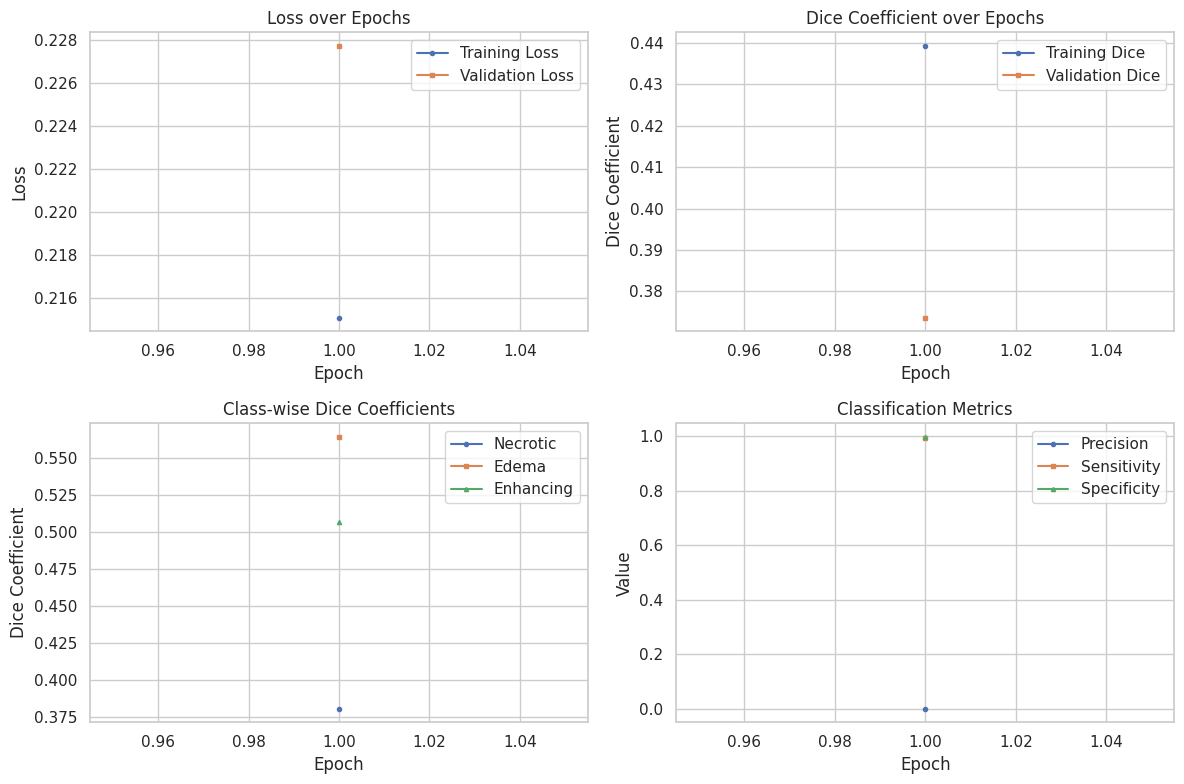

<Figure size 1000x500 with 0 Axes>

Using device: cuda
Step 1: Creating directories...
✓ Created directories: /kaggle/working/model_export
Step 2: Finding latest checkpoint and log files...
✓ Found checkpoint: UNet++_best_dice_01_0.37361.pt
✓ Found log file: training_UNet++_20250312_081842.log
Step 3: Plotting training metrics...
✓ Loaded log data with 1 entries
✓ Saved metrics plot to /kaggle/working/model_export/plots/training_metrics.png
Step 4: Loading model from checkpoint...


<ipython-input-23-168ff9d2ef67>:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


✓ Model state loaded successfully
✓ Saved PyTorch model to /kaggle/working/model_export/model_full.pt
Step 6: Running predictions on test data...
Step 5: Creating synthetic test data...
✓ Created 3 synthetic test samples
  Running predictions and generating visualizations...
❌ Error during prediction: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same
Step 7: Exporting model to ONNX format...


<ipython-input-17-f25dfd537cd3>:204: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if transformer_features.shape[2:] != bottleneck.shape[2:]:
<ipython-input-17-f25dfd537cd3>:147: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if x.shape[2] < 240:  # Assuming your input is 240x240


✓ Saved ONNX model to /kaggle/working/model_export/model.onnx
Step 8: Creating zip file of all outputs...
✓ Created zip file: /kaggle/working/model_export_20250312_115019.zip

✅ All done! Summary:
- Export directory: /kaggle/working/model_export
- Training metrics plot: /kaggle/working/model_export/plots/training_metrics.png
- Exported PyTorch model: /kaggle/working/model_export/model_full.pt
- Exported ONNX model: /kaggle/working/model_export/model.onnx
- Zip archive: /kaggle/working/model_export_20250312_115019.zip


<Figure size 1500x1200 with 0 Axes>

In [28]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import zipfile
import cv2
import nibabel as nib
from datetime import datetime
from matplotlib.colors import ListedColormap
from pathlib import Path

# Set correct input/output shapes based on your model
INPUT_CHANNELS = 2  # 2 input channels
INPUT_HEIGHT = 240  # Height 240
INPUT_WIDTH = 240   # Width 240
OUTPUT_CLASSES = 4  # 4 output classes (background + 3 tumor regions)

# Constants for the BraTS dataset
IMG_SIZE = 240
VOLUME_SLICES = 155
VOLUME_START_AT = 0
SEGMENT_CLASSES = {
    0: 'Background',
    1: 'Necrotic',
    2: 'Edema',
    3: 'Enhancing'
}

# Define the dataset path (adjust as needed)
# TRAIN_DATASET_PATH = '/kaggle/input/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/'

# Step 1: Create directories for saving outputs
def create_dirs():
    print("Step 1: Creating directories...")
    export_dir = os.path.join("/kaggle/working", "model_export")
    plot_dir = os.path.join(export_dir, "plots")
    pred_dir = os.path.join(export_dir, "predictions")
    
    os.makedirs(export_dir, exist_ok=True)
    os.makedirs(plot_dir, exist_ok=True)
    os.makedirs(pred_dir, exist_ok=True)
    
    print(f"✓ Created directories: {export_dir}")
    return export_dir, plot_dir, pred_dir

# Step 2: Find the latest checkpoint and log file
def find_latest_files():
    print("Step 2: Finding latest checkpoint and log files...")
    
    # Find checkpoint
    checkpoint_files = glob.glob(os.path.join('checkpoints', '*.pt'))
    if not checkpoint_files:
        print("❌ No checkpoint files found!")
        return None, None
    
    checkpoint_files.sort(key=os.path.getmtime, reverse=True)
    latest_checkpoint = checkpoint_files[0]
    
    # Find log file
    log_files = glob.glob(os.path.join('logs', '*.log'))
    if not log_files:
        print("❌ No log files found!")
        return latest_checkpoint, None
    
    log_files.sort(key=os.path.getmtime, reverse=True)
    latest_log = log_files[0]
    
    print(f"✓ Found checkpoint: {os.path.basename(latest_checkpoint)}")
    print(f"✓ Found log file: {os.path.basename(latest_log)}")
    
    return latest_checkpoint, latest_log

# Step 3: Plot training metrics from log file
def plot_metrics(log_file, plot_dir):
    print("Step 3: Plotting training metrics...")
    if not log_file or not os.path.exists(log_file):
        print("❌ Log file not available for plotting")
        return None
    
    try:
        # Read log file
        df = pd.read_csv(log_file)
        print(f"✓ Loaded log data with {len(df)} entries")
        
        # Create plot
        plt.figure(figsize=(12, 10))
        
        # Plot Loss
        plt.subplot(2, 2, 1)
        plt.plot(df['epoch'], df['loss'], label='Training', marker='o', markersize=3)
        plt.plot(df['epoch'], df['val_loss'], label='Validation', marker='s', markersize=3)
        plt.title('Loss')
        plt.xlabel('Epoch')
        plt.legend()
        
        # Plot Dice Coefficient
        plt.subplot(2, 2, 2)
        plt.plot(df['epoch'], df['dice_coef'], label='Training', marker='o', markersize=3)
        plt.plot(df['epoch'], df['val_dice_coef'], label='Validation', marker='s', markersize=3)
        plt.title('Dice Coefficient')
        plt.xlabel('Epoch')
        plt.legend()
        
        # Plot Class-wise Dice
        plt.subplot(2, 2, 3)
        if 'dice_necrotic' in df.columns:
            plt.plot(df['epoch'], df['dice_necrotic'], label='Necrotic', marker='o', markersize=3)
            plt.plot(df['epoch'], df['dice_edema'], label='Edema', marker='s', markersize=3)
            plt.plot(df['epoch'], df['dice_enhancing'], label='Enhancing', marker='^', markersize=3)
            plt.title('Class-wise Dice')
            plt.xlabel('Epoch')
            plt.legend()
        
        # Plot Other Metrics
        plt.subplot(2, 2, 4)
        if 'precision' in df.columns:
            plt.plot(df['epoch'], df['precision'], label='Precision', marker='o', markersize=3)
            plt.plot(df['epoch'], df['sensitivity'], label='Sensitivity', marker='s', markersize=3)
            plt.plot(df['epoch'], df['specificity'], label='Specificity', marker='^', markersize=3)
            plt.title('Other Metrics')
            plt.xlabel('Epoch')
            plt.legend()
        
        plt.tight_layout()
        
        # Save the plot
        metrics_plot_path = os.path.join(plot_dir, "training_metrics.png")
        plt.savefig(metrics_plot_path, dpi=300)
        plt.close()
        
        print(f"✓ Saved metrics plot to {metrics_plot_path}")
        return metrics_plot_path
        
    except Exception as e:
        print(f"❌ Error plotting metrics: {e}")
        return None

# Step 4: Load model from checkpoint
def load_model(checkpoint_path, export_dir, device='cpu'):
    print("Step 4: Loading model from checkpoint...")
    if not checkpoint_path or not os.path.exists(checkpoint_path):
        print("❌ Checkpoint not available")
        return None
    
    try:
        # Load the checkpoint
        checkpoint = torch.load(checkpoint_path, map_location=device)
        model_state_dict = checkpoint['model_state_dict']
        
        # Assuming model is already defined in global scope 
        # but providing a fallback message
        if 'model' not in globals():
            print("❌ 'model' variable not found in global scope. Make sure your model is defined.")
            print("   For testing purposes, the code will continue but may fail.")
        
        # Load state dict into model
        model.load_state_dict(model_state_dict)
        model.eval()
        print("✓ Model state loaded successfully")
        
        # Save the PyTorch model for later use
        torch_model_path = os.path.join(export_dir, "model_full.pt")
        torch.save(model, torch_model_path)
        print(f"✓ Saved PyTorch model to {torch_model_path}")
        
        return model, torch_model_path
    
    except Exception as e:
        print(f"❌ Error loading model: {e}")
        return None, None

# Step 6: Run predictions on real data (replaces the synthetic data prediction)
def predict_on_real_data(loaded_model, pred_dir, device='cpu'):
    print("Step 6: Running predictions on real BraTS data...")
    
    if loaded_model is None:
        print("❌ Model not available for prediction")
        return None
    
    try:
        # Test cases
        test_cases = [
            'BraTS2021_00124', 'BraTS2021_00054', 'BraTS2021_01172', 
            'BraTS2021_00191', 'BraTS2021_01342', 'BraTS2021_00097'
        ]
        
        # Check if dataset exists
        if not os.path.exists(TRAIN_DATASET_PATH):
            print(f"❌ Dataset path not found: {TRAIN_DATASET_PATH}")
            print("  Falling back to synthetic data prediction...")
            return predict_on_synthetic_data(loaded_model, pred_dir, device)
        
        # In the predict_on_real_data function, modify the predict_by_path function:
        def predict_by_path(case_path, case):
            print(f"  Processing case: {case}")
            
            vol_path_flair = os.path.join(case_path, f'{case}_flair.nii.gz')
            print(f'  Flair image path: {vol_path_flair}')
            
            try:
                flair = nib.load(vol_path_flair).get_fdata()
            except FileNotFoundError:
                print(f"  ❌ Error: Flair image file not found for case {case}")
                return None
            
            # Prepare input tensor
            X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, INPUT_CHANNELS))
            for j in range(VOLUME_SLICES):
                X[j, :, :, 0] = cv2.resize(flair[:, :, j + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE))
                # Add zeros for second channel if needed (or add t1ce data)
                X[j, :, :, 1] = np.zeros((IMG_SIZE, IMG_SIZE))
            
            # Convert to PyTorch tensor and normalize
            X_tensor = torch.tensor(X / np.max(X), dtype=torch.float32).permute(0, 3, 1, 2)
            
            # Predict using loaded model
            predictions = []
            with torch.no_grad():
                batch_size = 8  # Process in batches to save memory
                for i in range(0, VOLUME_SLICES, batch_size):
                    batch = X_tensor[i:min(i+batch_size, VOLUME_SLICES)].to(device)
                    # Move model to the same device as input data before inference
                    outputs = loaded_model.to(device)(batch)
                    pred_batch = torch.sigmoid(outputs).cpu().numpy()
                    predictions.append(pred_batch)
                    
            return np.vstack(predictions)
        # Function to create visualization for a specific case
        def visualize_case(case, start_slice=60, pred_dir=pred_dir):
            print(f"  Visualizing case: {case}, slice: {start_slice}")
            path = os.path.join(TRAIN_DATASET_PATH, case)
            
            try:
                # Load ground truth and original image
                gt_path = os.path.join(path, f'{case}_seg.nii.gz')
                if os.path.exists(gt_path):
                    gt = nib.load(gt_path).get_fdata()
                else:
                    print(f"  ⚠️ Ground truth not found for case {case}")
                    gt = np.zeros((240, 240, 155))  # Create empty ground truth
                
                orig_path = os.path.join(path, f'{case}_flair.nii.gz')
                if not os.path.exists(orig_path):
                    print(f"  ❌ Original image not found for case {case}")
                    return None
                    
                orig_image = nib.load(orig_path).get_fdata()
                
                # Get predictions
                p = predict_by_path(path, case)
                if p is None:
                    return None
                
                # Extract different tumor regions
                core = p[:, 1, :, :]  # Necrotic core
                edema = p[:, 2, :, :]  # Edema
                enhancing = p[:, 3, :, :]  # Enhancing tumor
                
                # Create figure
                plt.figure(figsize=(15, 5))
                
                # Original image
                plt.subplot(1, 5, 1)
                plt.imshow(cv2.resize(orig_image[:, :, start_slice + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
                plt.title('Original FLAIR')
                plt.axis('off')
                
                # Ground truth
                plt.subplot(1, 5, 2)
                plt.imshow(cv2.resize(orig_image[:, :, start_slice + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
                curr_gt = cv2.resize(gt[:, :, start_slice + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)
                plt.imshow(curr_gt, cmap="Reds", interpolation='none', alpha=0.3)
                plt.title('Ground Truth')
                plt.axis('off')
                
                # All classes prediction
                plt.subplot(1, 5, 3)
                plt.imshow(cv2.resize(orig_image[:, :, start_slice + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
                all_classes = np.zeros((IMG_SIZE, IMG_SIZE, 3))
                all_classes[:, :, 0] = core[start_slice]
                all_classes[:, :, 1] = edema[start_slice]
                all_classes[:, :, 2] = enhancing[start_slice]
                plt.imshow(all_classes, interpolation='none', alpha=0.3)
                plt.title('All Classes')
                plt.axis('off')
                
                # Core prediction
                plt.subplot(1, 5, 4)
                plt.imshow(cv2.resize(orig_image[:, :, start_slice + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
                plt.imshow(core[start_slice], cmap="OrRd", interpolation='none', alpha=0.3)
                plt.title(f'{SEGMENT_CLASSES[1]} Core')
                plt.axis('off')
                
                # Edema prediction
                plt.subplot(1, 5, 5)
                plt.imshow(cv2.resize(orig_image[:, :, start_slice + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
                plt.imshow(edema[start_slice], cmap="OrRd", interpolation='none', alpha=0.3)
                plt.title(f'{SEGMENT_CLASSES[2]} Edema')
                plt.axis('off')
                
                # Save the figure
                plt.tight_layout()
                pred_path = os.path.join(pred_dir, f"prediction_{case}_slice{start_slice}.png")
                plt.savefig(pred_path, dpi=200, bbox_inches='tight')
                plt.close()
                
                return pred_path
                
            except Exception as e:
                print(f"  ❌ Error visualizing case {case}: {e}")
                return None
        
        # Process all test cases
        print("  Processing test cases and generating visualizations...")
        success_paths = []
        
        for case in test_cases:
            try:
                result_path = visualize_case(case, start_slice=80)
                if result_path:
                    success_paths.append(result_path)
                    print(f"  ✓ Successfully processed case {case}")
                else:
                    print(f"  ⚠️ Failed to process case {case}")
            except Exception as e:
                print(f"  ❌ Error processing case {case}: {e}")
        
        # Create a montage of all successful predictions
        if success_paths:
            plt.figure(figsize=(15, len(success_paths) * 5))
            for i, path in enumerate(success_paths):
                plt.subplot(len(success_paths), 1, i+1)
                img = plt.imread(path)
                plt.imshow(img)
                plt.axis('off')
                plt.title(f"Case {os.path.basename(path).split('_')[1]}")
            
            montage_path = os.path.join(pred_dir, "predictions_montage.png")
            plt.tight_layout()
            plt.savefig(montage_path, dpi=200)
            plt.close()
            
            print(f"✓ Saved prediction montage to {montage_path}")
            return montage_path
        else:
            print("❌ No successful predictions to create montage")
            return None
        
    except Exception as e:
        print(f"❌ Error during prediction on real data: {e}")
        print("  Falling back to synthetic data prediction...")
        return predict_on_synthetic_data(loaded_model, pred_dir, device)

# Fallback to synthetic data prediction if real data not available
def predict_on_synthetic_data(loaded_model, pred_dir, device='cpu'):
    print("Using synthetic test data instead...")
    
    try:
        # Create tensors for images and masks (3 samples)
        images = torch.randn(3, INPUT_CHANNELS, INPUT_HEIGHT, INPUT_WIDTH)
        masks = torch.zeros(3, OUTPUT_CLASSES, INPUT_HEIGHT, INPUT_WIDTH)
        
        # Create simple patterns in the masks
        for i in range(3):
            # Create center coordinates and radii
            center_x, center_y = np.random.randint(80, 160, 2)
            radius_edema = np.random.randint(30, 60)
            radius_necrotic = np.random.randint(10, 25)
            radius_enhancing = np.random.randint(5, 15)
            
            # Create coordinate grids
            y, x = np.ogrid[:INPUT_HEIGHT, :INPUT_WIDTH]
            dist_from_center = np.sqrt((x - center_x) ** 2 + (y - center_y) ** 2)
            
            # Create masks for each tumor component
            masks[i, 1, dist_from_center < radius_necrotic] = 1  # Necrotic core
            masks[i, 2, dist_from_center < radius_edema] = 1     # Edema
            masks[i, 3, (dist_from_center > radius_necrotic) & 
                       (dist_from_center < radius_necrotic + radius_enhancing)] = 1  # Enhancing
        
        # Setup visualization
        colors = [(0, 0, 0), (1, 0, 0), (0, 1, 0), (0, 0, 1)]  # Black, Red, Green, Blue
        custom_cmap = ListedColormap(colors)
        
        # Run predictions
        print("  Running predictions on synthetic data...")
        montage_fig = plt.figure(figsize=(15, 12))
        
        with torch.no_grad():
            for i in range(len(images)):
                # Get prediction
                image = images[i:i+1].to(device)
                output = loaded_model(image)
                prediction = torch.sigmoid(output)
                
                # Convert to numpy for visualization
                image_np = image[0].cpu().numpy()
                mask_np = masks[i].cpu().numpy()
                pred_np = prediction[0].cpu().numpy()
                
                # Get class predictions
                pred_mask = np.argmax(pred_np, axis=0)
                true_mask = np.argmax(mask_np, axis=0)
                
                # Create visualization
                plt.figure(figsize=(15, 5))
                
                # Original image
                plt.subplot(1, 3, 1)
                plt.imshow(image_np[0], cmap='gray')
                plt.title('Synthetic MRI Image')
                plt.axis('off')
                
                # Ground truth
                plt.subplot(1, 3, 2)
                plt.imshow(true_mask, cmap=custom_cmap, vmin=0, vmax=3)
                plt.title('Ground Truth')
                plt.axis('off')
                
                # Prediction
                plt.subplot(1, 3, 3)
                plt.imshow(pred_mask, cmap=custom_cmap, vmin=0, vmax=3)
                plt.title('Prediction')
                plt.axis('off')
                
                # Add a legend
                import matplotlib.patches as mpatches
                patches = [
                    mpatches.Patch(color='black', label='Background'),
                    mpatches.Patch(color='red', label='Necrotic'),
                    mpatches.Patch(color='green', label='Edema'),
                    mpatches.Patch(color='blue', label='Enhancing')
                ]
                plt.figlegend(handles=patches, loc='lower center', ncol=4)
                
                plt.tight_layout()
                
                # Save individual prediction
                pred_path = os.path.join(pred_dir, f"synthetic_prediction_{i+1}.png")
                plt.savefig(pred_path, dpi=200, bbox_inches='tight')
                plt.close()
                
                # Add to montage
                ax = montage_fig.add_subplot(3, 1, i+1)
                img = plt.imread(pred_path)
                ax.imshow(img)
                ax.axis('off')
                ax.set_title(f"Synthetic Sample {i+1}")
            
            # Save montage
            montage_path = os.path.join(pred_dir, "synthetic_predictions_montage.png")
            montage_fig.tight_layout()
            montage_fig.savefig(montage_path, dpi=200)
            plt.close()
            
            print(f"✓ Saved synthetic prediction montage to {montage_path}")
            return montage_path
            
    except Exception as e:
        print(f"❌ Error during synthetic prediction: {e}")
        return None

# Step 7: Export model to ONNX format
def export_to_onnx(loaded_model, export_dir):
    print("Step 7: Exporting model to ONNX format...")
    
    if loaded_model is None:
        print("❌ Model not available for ONNX export")
        return None
    
    try:
        # Export to ONNX format with higher opset version
        onnx_path = os.path.join(export_dir, "model.onnx")
        dummy_input = torch.randn(1, INPUT_CHANNELS, INPUT_HEIGHT, INPUT_WIDTH)
        
        torch.onnx.export(
            loaded_model.to('cpu'),
            dummy_input,
            onnx_path,
            export_params=True,
            opset_version=14,
            do_constant_folding=True,
            input_names=['input'],
            output_names=['output'],
            dynamic_axes={'input': {0: 'batch_size'},
                         'output': {0: 'batch_size'}}
        )
        
        print(f"✓ Saved ONNX model to {onnx_path}")
        return onnx_path
    
    except Exception as e:
        print(f"❌ Error exporting to ONNX: {e}")
        print("  Continuing without ONNX export.")
        return None

# Step 8: Create a zip file of all exported files
def create_zip_file(export_dir):
    print("Step 8: Creating zip file of all outputs...")
    
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    zip_path = os.path.join("/kaggle/working", f"model_export_{timestamp}.zip")
    
    try:
        with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
            for root, dirs, files in os.walk(export_dir):
                for file in files:
                    file_path = os.path.join(root, file)
                    arcname = os.path.relpath(file_path, start=os.path.dirname(export_dir))
                    zipf.write(file_path, arcname)
        
        print(f"✓ Created zip file: {zip_path}")
        return zip_path
    except Exception as e:
        print(f"❌ Error creating zip file: {e}")
        return None

# Main function to run everything
def main():
    # For debugging purposes
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Using device: {device}")
    
    # Step 1: Create directories
    export_dir, plot_dir, pred_dir = create_dirs()
    
    # Step 2: Find latest files
    checkpoint_path, log_path = find_latest_files()
    if not checkpoint_path:
        print("❌ Cannot continue without a checkpoint file.")
        return
    
    # Step 3: Plot metrics
    if log_path:
        metrics_plot = plot_metrics(log_path, plot_dir)
    
    # Step 4: Load model from checkpoint
    loaded_model, model_path = load_model(checkpoint_path, export_dir, device)
    if loaded_model is None:
        print("❌ Cannot continue without loading the model.")
        return
    
    # Step 6: Run predictions on real data (replaces synthetic data)
    montage_path = predict_on_real_data(loaded_model, pred_dir, device)
    
    # Step 7: Export to ONNX
    onnx_path = export_to_onnx(loaded_model, export_dir)
    
    # Step 8: Create zip file
    zip_path = create_zip_file(export_dir)
    
    print("\n✅ All done! Summary:")
    print(f"- Export directory: {export_dir}")
    if 'metrics_plot' in locals() and metrics_plot:
        print(f"- Training metrics plot: {metrics_plot}")
    if 'model_path' in locals() and model_path:
        print(f"- Exported PyTorch model: {model_path}")
    if 'onnx_path' in locals() and onnx_path:
        print(f"- Exported ONNX model: {onnx_path}")
    if 'montage_path' in locals() and montage_path:
        print(f"- Prediction montage: {montage_path}")
    if 'zip_path' in locals() and zip_path:
        print(f"- Zip archive: {zip_path}")
    else:
        print("  Note: Some exports may have failed. Check the logs above for details.")

# Run everything
if __name__ == "__main__":
    main()

Using device: cuda
Step 1: Creating directories...
✓ Created directories: /kaggle/working/model_export
Step 2: Finding latest checkpoint and log files...
✓ Found checkpoint: UNet++_best_dice_01_0.37361.pt
✓ Found log file: training_UNet++_20250312_081842.log
Step 3: Plotting training metrics...
✓ Loaded log data with 1 entries
✓ Saved metrics plot to /kaggle/working/model_export/plots/training_metrics.png
Step 4: Loading model from checkpoint...


<ipython-input-28-da49e1edbafa>:149: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)


✓ Model state loaded successfully
✓ Saved PyTorch model to /kaggle/working/model_export/model_full.pt
Step 6: Running predictions on real BraTS data...
  Processing test cases and generating visualizations...
  Visualizing case: BraTS2021_00124, slice: 80
  Processing case: BraTS2021_00124
  Flair image path: ./BraTS2021_Training_Data/BraTS2021_00124/BraTS2021_00124_flair.nii.gz
  ✓ Successfully processed case BraTS2021_00124
  Visualizing case: BraTS2021_00054, slice: 80
  Processing case: BraTS2021_00054
  Flair image path: ./BraTS2021_Training_Data/BraTS2021_00054/BraTS2021_00054_flair.nii.gz
  ✓ Successfully processed case BraTS2021_00054
  Visualizing case: BraTS2021_01172, slice: 80
  Processing case: BraTS2021_01172
  Flair image path: ./BraTS2021_Training_Data/BraTS2021_01172/BraTS2021_01172_flair.nii.gz
  ✓ Successfully processed case BraTS2021_01172
  Visualizing case: BraTS2021_00191, slice: 80
  Processing case: BraTS2021_00191
  Flair image path: ./BraTS2021_Training_Data/

<ipython-input-17-f25dfd537cd3>:204: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if transformer_features.shape[2:] != bottleneck.shape[2:]:
<ipython-input-17-f25dfd537cd3>:147: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if x.shape[2] < 240:  # Assuming your input is 240x240


✓ Saved ONNX model to /kaggle/working/model_export/model.onnx
Step 8: Creating zip file of all outputs...
✓ Created zip file: /kaggle/working/model_export_20250312_125402.zip

✅ All done! Summary:
- Export directory: /kaggle/working/model_export
- Training metrics plot: /kaggle/working/model_export/plots/training_metrics.png
- Exported PyTorch model: /kaggle/working/model_export/model_full.pt
- Exported ONNX model: /kaggle/working/model_export/model.onnx
- Prediction montage: /kaggle/working/model_export/predictions/predictions_montage.png
- Zip archive: /kaggle/working/model_export_20250312_125402.zip


In [ ]:
import os
import glob
import time
import psutil
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import nibabel as nib
from pathlib import Path

# Performance monitoring
def get_memory_usage():
    """Return memory usage in MB"""
    process = psutil.Process(os.getpid())
    return process.memory_info().rss / (1024 * 1024)

# Constants for the BraTS dataset
IMG_SIZE = 240
VOLUME_SLICES = 155
VOLUME_START_AT = 0
SEGMENT_CLASSES = {
    0: 'Background',
    1: 'Necrotic',
    2: 'Edema',
    3: 'Enhancing'
}

# Function to crop brain region
def crop_brain_region(image, threshold=0.05):
    """Crop the brain region from the image"""
    # Normalize the image
    normalized = image / np.max(image)
    
    # Create binary mask where the brain is
    brain_mask = normalized > threshold
    
    # Find bounding box
    coords = np.argwhere(brain_mask)
    if len(coords) == 0:  # No brain found
        return image
        
    y_min, x_min = coords.min(axis=0)
    y_max, x_max = coords.max(axis=0)
    
    # Add padding
    padding = 10
    y_min = max(0, y_min - padding)
    y_max = min(image.shape[0], y_max + padding)
    x_min = max(0, x_min - padding)
    x_max = min(image.shape[1], x_max + padding)
    
    # Crop brain region
    cropped = image[y_min:y_max, x_min:x_max]
    
    # Resize back to original size for model compatibility
    return cv2.resize(cropped, (IMG_SIZE, IMG_SIZE))

# Create directories
def setup_output_dirs():
    pred_dir = os.path.join(os.getcwd(), "predictions")
    os.makedirs(pred_dir, exist_ok=True)
    print(f"✓ Created prediction directory: {pred_dir}")
    return pred_dir

# Load model from checkpoint
def load_model(device='cpu'):
    print("Loading model from checkpoint...")
    
    # Find checkpoint
    checkpoint_files = glob.glob(os.path.join('checkpoints', '*.pt'))
    if not checkpoint_files:
        raise FileNotFoundError("No checkpoint files found!")
    
    checkpoint_files.sort(key=os.path.getmtime, reverse=True)
    latest_checkpoint = checkpoint_files[0]
    print(f"✓ Using checkpoint: {os.path.basename(latest_checkpoint)}")
    
    # Load the checkpoint
    checkpoint = torch.load(latest_checkpoint, map_location=device)
    
    # Attempt to load full model first
    if 'model' in checkpoint:
        model = checkpoint['model']
        print("✓ Full model loaded from checkpoint")
    else:
        # If only state_dict is present, need model definition
        if 'model' not in globals():
            raise ValueError("Model definition required but not found in globals")
        
        model_state_dict = checkpoint['model_state_dict']
        model.load_state_dict(model_state_dict)
        print("✓ Model state loaded from checkpoint")
    
    # Save as full model
    torch_model_path = os.path.join(os.getcwd(), "model_full.pt")
    torch.save(model, torch_model_path)
    print(f"✓ Saved PyTorch model to {torch_model_path}")
    
    return model, torch_model_path

# Run predictions on test cases
def predict_on_test_cases(loaded_model, pred_dir, device='cpu'):
    print("Running predictions on test cases with performance metrics...")
    
    # Test cases
    test_cases = [
        'BraTS2021_00124', 'BraTS2021_00054', 'BraTS2021_01172', 
        'BraTS2021_00191', 'BraTS2021_01342', 'BraTS2021_00097'
    ]
    
    # Performance metrics
    performance_metrics = {
        'load_time': [],
        'preprocessing_time': [],
        'inference_time': [],
        'memory_before': [],
        'memory_after': [],
        'total_time': []
    }
    
    # Define dataset path - adjust as needed
    TRAIN_DATASET_PATH = '/kaggle/working/BraTS2021_Training_Data'
    
    # Prediction function with brain cropping
    def predict_by_path(case_path, case):
        print(f"  Processing case: {case}")
        
        # Track memory before loading
        memory_before = get_memory_usage()
        performance_metrics['memory_before'].append(memory_before)
        
        # Record start time for loading
        load_start = time.time()
        
        vol_path_flair = os.path.join(case_path, f'{case}_flair.nii.gz')
        print(f'  Flair image path: {vol_path_flair}')
        
        try:
            flair = nib.load(vol_path_flair).get_fdata()
        except FileNotFoundError:
            print(f"  ❌ Error: Flair image file not found for case {case}")
            return None
            
        load_time = time.time() - load_start
        performance_metrics['load_time'].append(load_time)
        
        # Record preprocessing time (including brain cropping)
        preprocess_start = time.time()
        
        X = np.empty((VOLUME_SLICES, IMG_SIZE, IMG_SIZE, 2))
        for j in range(VOLUME_SLICES):
            # Apply brain cropping
            cropped_brain = crop_brain_region(flair[:, :, j + VOLUME_START_AT])
            X[j, :, :, 0] = cropped_brain
            # Add zeros for second channel 
            X[j, :, :, 1] = np.zeros((IMG_SIZE, IMG_SIZE))
        
        # Convert to PyTorch tensor and normalize
        X_tensor = torch.tensor(X / np.max(X), dtype=torch.float32).permute(0, 3, 1, 2)
        
        preprocess_time = time.time() - preprocess_start
        performance_metrics['preprocessing_time'].append(preprocess_time)
        
        # Predict using loaded model
        inference_start = time.time()
        
        predictions = []
        with torch.no_grad():
            batch_size = 8  # Process in batches to save memory
            for i in range(0, VOLUME_SLICES, batch_size):
                batch = X_tensor[i:min(i+batch_size, VOLUME_SLICES)].to(device)
                outputs = loaded_model.to(device)(batch)
                pred_batch = torch.sigmoid(outputs).cpu().numpy()
                predictions.append(pred_batch)
        
        inference_time = time.time() - inference_start
        performance_metrics['inference_time'].append(inference_time)
        
        # Track memory after inference
        memory_after = get_memory_usage()
        performance_metrics['memory_after'].append(memory_after)
        
        total_time = load_time + preprocess_time + inference_time
        performance_metrics['total_time'].append(total_time)
        
        print(f"  ✓ Case {case} processed in {total_time:.2f}s (Load: {load_time:.2f}s, Preprocess: {preprocess_time:.2f}s, Inference: {inference_time:.2f}s)")
        print(f"  ✓ Memory usage: {memory_before:.2f}MB → {memory_after:.2f}MB (Δ: {memory_after-memory_before:.2f}MB)")
        
        return np.vstack(predictions), flair

    # Function to create visualization for a specific case
    def visualize_case(case, start_slice=80):
        print(f"  Visualizing case: {case}, slice: {start_slice}")
        path = os.path.join(TRAIN_DATASET_PATH, case)
        
        try:
            # Get predictions and original image
            p, orig_image = predict_by_path(path, case)
            if p is None:
                return None
            
            # Load ground truth if available
            gt_path = os.path.join(path, f'{case}_seg.nii.gz')
            if os.path.exists(gt_path):
                gt = nib.load(gt_path).get_fdata()
                has_gt = True
            else:
                print(f"  ⚠️ Ground truth not found for case {case}")
                gt = np.zeros((240, 240, 155))  # Create empty ground truth
                has_gt = False
            
            # Extract different tumor regions
            core = p[:, 1, :, :]      # Necrotic core
            edema = p[:, 2, :, :]     # Edema
            enhancing = p[:, 3, :, :] # Enhancing tumor
            
            # Get the original slice and crop the brain
            orig_slice = orig_image[:, :, start_slice + VOLUME_START_AT]
            cropped_brain = crop_brain_region(orig_slice)
            
            # If we have ground truth, also crop it
            if has_gt:
                gt_slice = gt[:, :, start_slice + VOLUME_START_AT]
                # Ensure gt_slice is cropped exactly like the brain image
                # First, get the bounds from the original image
                normalized = orig_slice / np.max(orig_slice)
                brain_mask = normalized > 0.05
                coords = np.argwhere(brain_mask)
                
                if len(coords) > 0:
                    y_min, x_min = coords.min(axis=0)
                    y_max, x_max = coords.max(axis=0)
                    
                    # Add padding
                    padding = 10
                    y_min = max(0, y_min - padding)
                    y_max = min(orig_slice.shape[0], y_max + padding)
                    x_min = max(0, x_min - padding)
                    x_max = min(orig_slice.shape[1], x_max + padding)
                    
                    # Crop gt with the same bounds
                    gt_slice_cropped = gt_slice[y_min:y_max, x_min:x_max]
                    gt_slice_resized = cv2.resize(gt_slice_cropped, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)
                else:
                    # Fallback if no brain detected
                    gt_slice_resized = cv2.resize(gt_slice, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)
            
            # Create figure
            fig_cols = 5 if has_gt else 4
            plt.figure(figsize=(15, 5))
            
            # Original image (cropped brain)
            plt.subplot(1, fig_cols, 1)
            plt.imshow(cropped_brain, cmap="gray")
            plt.title('Cropped Brain FLAIR')
            plt.axis('off')
            
            # Ground truth if available
            if has_gt:
                plt.subplot(1, fig_cols, 2)
                plt.imshow(cropped_brain, cmap="gray")
                plt.imshow(gt_slice_resized, cmap="Reds", interpolation='none', alpha=0.3)
                plt.title('Ground Truth')
                plt.axis('off')
                
                start_idx = 3
            else:
                start_idx = 2
            
            # All classes prediction
            plt.subplot(1, fig_cols, start_idx)
            plt.imshow(cropped_brain, cmap="gray")
            all_classes = np.zeros((IMG_SIZE, IMG_SIZE, 3))
            all_classes[:, :, 0] = core[start_slice]
            all_classes[:, :, 1] = edema[start_slice]
            all_classes[:, :, 2] = enhancing[start_slice]
            plt.imshow(all_classes, interpolation='none', alpha=0.3)
            plt.title('All Classes')
            plt.axis('off')
            
            # Core prediction
            plt.subplot(1, fig_cols, start_idx+1)
            plt.imshow(cropped_brain, cmap="gray")
            plt.imshow(core[start_slice], cmap="OrRd", interpolation='none', alpha=0.3)
            plt.title(f'{SEGMENT_CLASSES[1]} Core')
            plt.axis('off')
            
            # Edema prediction
            plt.subplot(1, fig_cols, start_idx+2)
            plt.imshow(cropped_brain, cmap="gray")
            plt.imshow(edema[start_slice], cmap="OrRd", interpolation='none', alpha=0.3)
            plt.title(f'{SEGMENT_CLASSES[2]} Edema')
            plt.axis('off')
            
            # Save the figure
            plt.tight_layout()
            pred_path = os.path.join(pred_dir, f"prediction_{case}_slice{start_slice}.png")
            plt.savefig(pred_path, dpi=200, bbox_inches='tight')
            plt.close()
            
            return pred_path
                
        except Exception as e:
            print(f"  ❌ Error visualizing case {case}: {e}")
            return None
        
    # # Function to create visualization for a specific case
    # def visualize_case(case, start_slice=80):
    #     print(f"  Visualizing case: {case}, slice: {start_slice}")
    #     path = os.path.join(TRAIN_DATASET_PATH, case)
        
    #     try:
    #         # Get predictions and original image
    #         p, orig_image = predict_by_path(path, case)
    #         if p is None:
    #             return None
            
    #         # Load ground truth if available
    #         gt_path = os.path.join(path, f'{case}_seg.nii.gz')
    #         if os.path.exists(gt_path):
    #             gt = nib.load(gt_path).get_fdata()
    #             has_gt = True
    #         else:
    #             print(f"  ⚠️ Ground truth not found for case {case}")
    #             gt = np.zeros((240, 240, 155))  # Create empty ground truth
    #             has_gt = False
            
    #         # Extract different tumor regions
    #         core = p[:, 1, :, :]      # Necrotic core
    #         edema = p[:, 2, :, :]     # Edema
    #         enhancing = p[:, 3, :, :] # Enhancing tumor
            
    #         # Create figure
    #         fig_cols = 5 if has_gt else 4
    #         plt.figure(figsize=(15, 5))
            
    #         # Original image
    #         plt.subplot(1, fig_cols, 1)
    #         plt.imshow(cv2.resize(orig_image[:, :, start_slice + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    #         plt.title('Original FLAIR')
    #         plt.axis('off')
            
    #         # Ground truth if available
    #         if has_gt:
    #             plt.subplot(1, fig_cols, 2)
    #             plt.imshow(cv2.resize(orig_image[:, :, start_slice + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    #             curr_gt = cv2.resize(gt[:, :, start_slice + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)
    #             plt.imshow(curr_gt, cmap="Reds", interpolation='none', alpha=0.3)
    #             plt.title('Ground Truth')
    #             plt.axis('off')
                
    #             start_idx = 3
    #         else:
    #             start_idx = 2
            
    #         # All classes prediction
    #         plt.subplot(1, fig_cols, start_idx)
    #         plt.imshow(cv2.resize(orig_image[:, :, start_slice + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    #         all_classes = np.zeros((IMG_SIZE, IMG_SIZE, 3))
    #         all_classes[:, :, 0] = core[start_slice]
    #         all_classes[:, :, 1] = edema[start_slice]
    #         all_classes[:, :, 2] = enhancing[start_slice]
    #         plt.imshow(all_classes, interpolation='none', alpha=0.3)
    #         plt.title('All Classes')
    #         plt.axis('off')
            
    #         # Core prediction
    #         plt.subplot(1, fig_cols, start_idx+1)
    #         plt.imshow(cv2.resize(orig_image[:, :, start_slice + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    #         plt.imshow(core[start_slice], cmap="OrRd", interpolation='none', alpha=0.3)
    #         plt.title(f'{SEGMENT_CLASSES[1]} Core')
    #         plt.axis('off')
            
    #         # Edema prediction
    #         plt.subplot(1, fig_cols, start_idx+2)
    #         plt.imshow(cv2.resize(orig_image[:, :, start_slice + VOLUME_START_AT], (IMG_SIZE, IMG_SIZE)), cmap="gray")
    #         plt.imshow(edema[start_slice], cmap="OrRd", interpolation='none', alpha=0.3)
    #         plt.title(f'{SEGMENT_CLASSES[2]} Edema')
    #         plt.axis('off')
            
    #         # Save the figure
    #         plt.tight_layout()
    #         pred_path = os.path.join(pred_dir, f"prediction_{case}_slice{start_slice}.png")
    #         plt.savefig(pred_path, dpi=200, bbox_inches='tight')
    #         plt.close()
            
    #         return pred_path
                
    #     except Exception as e:
    #         print(f"  ❌ Error visualizing case {case}: {e}")
    #         return None
    
    # Process all test cases
    print("  Processing test cases and generating visualizations...")
    success_paths = []
    
    for case in test_cases:
        try:
            result_path = visualize_case(case, start_slice=80)
            if result_path:
                success_paths.append(result_path)
                print(f"  ✓ Successfully processed case {case}")
            else:
                print(f"  ⚠️ Failed to process case {case}")
        except Exception as e:
            print(f"  ❌ Error processing case {case}: {e}")
    
    # Create a montage of all successful predictions
    if success_paths:
        plt.figure(figsize=(15, len(success_paths) * 5))
        for i, path in enumerate(success_paths):
            plt.subplot(len(success_paths), 1, i+1)
            img = plt.imread(path)
            plt.imshow(img)
            plt.axis('off')
            plt.title(f"Case {os.path.basename(path).split('_')[1]}")
        
        montage_path = os.path.join(pred_dir, "predictions_montage.png")
        plt.tight_layout()
        plt.savefig(montage_path, dpi=200)
        plt.close()
        
        print(f"✓ Saved prediction montage to {montage_path}")
    
    # Plot performance metrics
    plot_performance_metrics(performance_metrics, pred_dir)
    
    return success_paths

# Plot performance metrics
def plot_performance_metrics(metrics, output_dir):
    print("Plotting performance metrics...")
    plt.figure(figsize=(15, 10))
    
    # Plot execution times
    plt.subplot(2, 1, 1)
    cases = range(len(metrics['total_time']))
    width = 0.2
    
    plt.bar([x - width for x in cases], metrics['load_time'], width, label='Load Time')
    plt.bar([x for x in cases], metrics['preprocessing_time'], width, label='Preprocessing Time')
    plt.bar([x + width for x in cases], metrics['inference_time'], width, label='Inference Time')
    
    plt.xlabel('Case')
    plt.ylabel('Time (seconds)')
    plt.title('Execution Time Breakdown')
    plt.legend()
    plt.xticks(cases)
    
    # Plot memory usage
    plt.subplot(2, 1, 2)
    plt.plot(cases, metrics['memory_before'], 'b-o', label='Memory Before')
    plt.plot(cases, metrics['memory_after'], 'r-o', label='Memory After')
    
    plt.xlabel('Case')
    plt.ylabel('Memory Usage (MB)')
    plt.title('Memory Usage')
    plt.legend()
    plt.xticks(cases)
    
    plt.tight_layout()
    metrics_path = os.path.join(output_dir, "performance_metrics.png")
    plt.savefig(metrics_path, dpi=200)
    plt.close()
    
    print(f"✓ Saved performance metrics plot to {metrics_path}")
    
    # Calculate and print average metrics
    print("\nPerformance Summary:")
    print(f"  Average load time: {np.mean(metrics['load_time']):.4f}s ± {np.std(metrics['load_time']):.4f}s")
    print(f"  Average preprocessing time: {np.mean(metrics['preprocessing_time']):.4f}s ± {np.std(metrics['preprocessing_time']):.4f}s")
    print(f"  Average inference time: {np.mean(metrics['inference_time']):.4f}s ± {np.std(metrics['inference_time']):.4f}s")
    print(f"  Average total time: {np.mean(metrics['total_time']):.4f}s ± {np.std(metrics['total_time']):.4f}s")
    print(f"  Average memory usage increase: {np.mean(np.array(metrics['memory_after']) - np.array(metrics['memory_before'])):.2f}MB")
    
    # Save metrics to file
    import json
    summary_metrics = {
        'avg_load_time': float(np.mean(metrics['load_time'])),
        'avg_preprocessing_time': float(np.mean(metrics['preprocessing_time'])),
        'avg_inference_time': float(np.mean(metrics['inference_time'])),
        'avg_total_time': float(np.mean(metrics['total_time'])),
        'avg_memory_increase': float(np.mean(np.array(metrics['memory_after']) - np.array(metrics['memory_before'])))
    }
    
    with open(os.path.join(output_dir, 'performance_summary.json'), 'w') as f:
        json.dump(summary_metrics, f, indent=4)
    
    return metrics_path

# Main function to run all steps
def main():
    start_time = time.time()
    print(f"Starting brain tumor prediction pipeline at {time.strftime('%Y-%m-%d %H:%M:%S')}")
    
    # Check for GPU
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Using device: {device}")
    
    # Setup directories
    pred_dir = setup_output_dirs()
    
    try:
        # Try to load existing model_full.pt if available
        model_path = "/kaggle/input/medvision/pytorch/default/1/model_full.pt"
        if os.path.exists(model_path):
            print(f"Loading existing model from {model_path}")
            loaded_model = torch.load(model_path, map_location=device)
        else:
            # Load model from checkpoint
            loaded_model, model_path = load_model(device)
        
        if loaded_model is None:
            print("❌ Cannot continue without loading the model.")
            return
        
        # Set model to evaluation mode
        loaded_model.eval()
        
        # Run predictions with brain cropping and get performance metrics
        predict_on_test_cases(loaded_model, pred_dir, device)
        
        total_time = time.time() - start_time
        print(f"\n✅ All done! Pipeline completed in {total_time:.2f} seconds.")
        
    except Exception as e:
        print(f"❌ Error during execution: {e}")
        import traceback
        traceback.print_exc()

# Run everything
if __name__ == "__main__":
    main()

In [ ]:
!pip install captum

In [18]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import cv2
import nibabel as nib
from pathlib import Path
from captum.attr import IntegratedGradients, LayerGradCam

# Constants for the BraTS dataset
IMG_SIZE = 240
VOLUME_SLICES = 155
VOLUME_START_AT = 22
INPUT_CHANNELS = 2
OUTPUT_CLASSES = 4
SEGMENT_CLASSES = {
    0: 'Background',
    1: 'Necrotic',
    2: 'Edema',
    3: 'Enhancing'
}

# ===================== STEP 1: UTILITY FUNCTIONS =====================

def crop_brain_region(image, threshold=0.05):
    """Crop the brain region from the image"""
    # Normalize the image
    normalized = image / np.max(image)
    
    # Create binary mask where the brain is
    brain_mask = normalized > threshold
    
    # Find bounding box
    coords = np.argwhere(brain_mask)
    if len(coords) == 0:  # No brain found
        return image
        
    y_min, x_min = coords.min(axis=0)
    y_max, x_max = coords.max(axis=0)
    
    # Add padding
    padding = 10
    y_min = max(0, y_min - padding)
    y_max = min(image.shape[0], y_max + padding)
    x_min = max(0, x_min - padding)
    x_max = min(image.shape[1], x_max + padding)
    
    # Crop brain region
    cropped = image[y_min:y_max, x_min:x_max]
    
    # Resize back to original size for model compatibility
    return cv2.resize(cropped, (IMG_SIZE, IMG_SIZE))
    
def normalize_for_display(attr_map):
    """Normalize an attribution map for display"""
    if np.max(np.abs(attr_map)) > 0:
        attr_map = attr_map / np.max(np.abs(attr_map))
        # Shift to [0, 1] range for display
        attr_map = (attr_map + 1) / 2
    return attr_map

def overlay_heatmap(attr_map, original_img, colormap=cv2.COLORMAP_JET, alpha=0.4):
    """Create a heatmap overlay on the original image - standalone function"""
    # Ensure attr_map is in range [0, 1]
    attr_map = np.clip(attr_map, 0, 1)
    
    # Convert to uint8 for colormap
    heatmap = np.uint8(attr_map * 255)
    heatmap = cv2.applyColorMap(heatmap, colormap)
    
    # Convert to RGB
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
    
    # Normalize original image if needed
    if original_img.max() > 1:
        original_img = original_img / original_img.max()
    
    # Convert grayscale to RGB if needed
    if len(original_img.shape) == 2:
        original_img = np.stack([original_img] * 3, axis=2)
    elif len(original_img.shape) > 2 and original_img.shape[2] == 1:
        original_img = np.concatenate([original_img] * 3, axis=2)
    
    # Create overlay
    overlay = (1-alpha) * original_img + alpha * heatmap / 255.0
    overlay = np.clip(overlay, 0, 1)
    
    return overlay

# ===================== STEP 2: SLICE EXPLAINER =====================

class SLICEExplainer:
    """SLICE (Synthetic Labeled Input Counterfactual Explanations) implementation"""
    def __init__(self, model=None, num_samples=10, perturbation_std=0.1):
        self.model = model
        self.num_samples = num_samples
        self.perturbation_std = perturbation_std
    
    def set_model(self, model):
        """Set model after initialization"""
        self.model = model
    
    def explain(self, input_tensor, target_class):
        """
        Generate SLICE explanation by analyzing model's response to perturbed inputs
        """
        if self.model is None:
            print("Model not available for SLICE")
            return np.zeros((IMG_SIZE, IMG_SIZE))
            
        device = input_tensor.device
        batch_size, channels, height, width = input_tensor.shape
        
        # Initialize attention map
        attention_map = torch.zeros((height, width), device=device)
        
        try:
            # Original prediction
            with torch.no_grad():
                original_output = self.model(input_tensor)
                original_pred = torch.sigmoid(original_output)[0, target_class]
                # Get mean prediction value for the target class
                original_score = original_pred.mean().item()
            
            # Create perturbations and track prediction changes
            for i in range(self.num_samples):
                # Create noise with gradually increasing perturbation
                scale = self.perturbation_std * (i + 1) / self.num_samples
                noise = torch.randn_like(input_tensor) * scale
                perturbed_input = input_tensor + noise
                
                # Get prediction
                with torch.no_grad():
                    output = self.model(perturbed_input)
                    pred = torch.sigmoid(output)[0, target_class]
                    # Get mean prediction value for the target class
                    pred_score = pred.mean().item()
                
                # Calculate change in prediction
                pred_diff = abs(pred_score - original_score)
                
                # Calculate pixel-wise difference weighted by prediction change
                input_diff = torch.abs(perturbed_input - input_tensor).mean(dim=1).squeeze()
                weighted_diff = input_diff * pred_diff
                
                # Add to attention map
                attention_map += weighted_diff.detach()
            
            # Normalize attention map
            if torch.max(attention_map) > 0:
                attention_map = attention_map / torch.max(attention_map)
            
            return attention_map.cpu().numpy()
            
        except Exception as e:
            print(f"Error in SLICE: {e}")
            return np.zeros((height, width))

# ===================== STEP 3: GRAD-CAM EXPLAINER =====================

class GradCAMExplainer:
    """Grad-CAM explainer for medical vision models"""
    def __init__(self, model=None, target_layer=None):
        self.model = model
        self.target_layer = target_layer
        
    def set_model(self, model):
        """Set model after initialization"""
        self.model = model
        # Try to automatically find target layer
        if hasattr(model, 'fusion') and len(model.fusion) > 0:
            self.target_layer = model.fusion[0]
        elif hasattr(model, 'encoder') and hasattr(model.encoder, 'blocks'):
            self.target_layer = model.encoder.blocks[-1][-1]
    
    def explain(self, input_tensor, target_class):
        """Generate GradCAM explanation"""
        if self.model is None or self.target_layer is None:
            print("Model or target layer not available for GradCAM")
            return np.zeros((IMG_SIZE, IMG_SIZE))
        
        try:
            # Create a wrapper function that returns a scalar output for the target class
            def wrapper_fn(inputs):
                outputs = self.model(inputs)
                # Sum over spatial dimensions to get scalar per batch item
                return outputs[:, target_class].sum(dim=[1, 2])
            
            # Setup
            layer_gc = LayerGradCam(wrapper_fn, self.target_layer)
            
            # Generate attributions
            attributions = layer_gc.attribute(input_tensor)
            
            # Convert to numpy for visualization
            attr_map = attributions.squeeze().cpu().detach().numpy()
            
            # Upsample to match input size if needed
            if attr_map.shape != (IMG_SIZE, IMG_SIZE):
                attr_map = cv2.resize(attr_map, (IMG_SIZE, IMG_SIZE))
            
            # Normalize
            attr_map = normalize_for_display(attr_map)
            
            return attr_map
            
        except Exception as e:
            print(f"Error in GradCAM: {e}")
            return np.zeros((IMG_SIZE, IMG_SIZE))

# ===================== STEP 4: ATTENTION MAP EXTRACTOR =====================

class AttentionMapExtractor:
    """Extracts attention maps from transformer blocks in the model"""
    def __init__(self, model=None):
        self.model = model
        self.attention_maps = []
        self.hooks = []
        
        if model is not None:
            self.register_hooks()
    
    def set_model(self, model):
        """Set model after initialization"""
        self.model = model
        self.register_hooks()
    
    def register_hooks(self):
        """Register hooks to capture attention maps"""
        # Clear any previous hooks
        self.remove_hooks()
        
        # Try to register hooks on the transformer if it exists
        if self.model is None:
            return
            
        if hasattr(self.model, 'transformer') and hasattr(self.model.transformer, 'transformer'):
            self._register_hooks()
    
    def _register_hooks(self):
        """Register hooks to capture attention maps"""
        def hook_fn(module, input, output):
            # For transformer models, try to extract attention weights
            if hasattr(output, 'attentions') and output.attentions is not None:
                self.attention_maps.append(output.attentions)
        
        # Find transformer blocks to hook
        try:
            if hasattr(self.model.transformer.transformer, 'encoder') and \
               hasattr(self.model.transformer.transformer.encoder, 'layer'):
                for layer in self.model.transformer.transformer.encoder.layer:
                    if hasattr(layer, 'attention'):
                        hook = layer.attention.register_forward_hook(hook_fn)
                        self.hooks.append(hook)
        except AttributeError:
            print("Could not register attention hooks - transformer structure not found")
    
    def get_attention(self, input_tensor):
        """Get attention maps for an input"""
        if self.model is None:
            print("Model not available for attention extraction")
            return np.zeros((IMG_SIZE, IMG_SIZE))
            
        # Clear previous attention maps
        self.attention_maps = []
        
        try:
            # Forward pass
            with torch.no_grad():
                _ = self.model(input_tensor)
            
            # If we captured any attention maps
            if self.attention_maps:
                # Average across layers and heads
                all_attentions = []
                for layer_attentions in self.attention_maps:
                    # Average across heads
                    if isinstance(layer_attentions, tuple):
                        layer_attentions = layer_attentions[0]  # Get first item if it's a tuple
                    
                    avg_attention = layer_attentions.mean(dim=1)  # Average across heads
                    all_attentions.append(avg_attention)
                
                if all_attentions:
                    # Stack and average across layers
                    avg_attention = torch.stack(all_attentions).mean(dim=0)
                    
                    # Get spatial dimensions for attention map reshaping
                    h = w = int(np.sqrt(avg_attention.shape[-1]))
                    
                    # Reshape to spatial dimensions and get the diagonal (self-attention)
                    attention_map = avg_attention.reshape(avg_attention.shape[0], h, w)
                    attention_map = attention_map[0].cpu().numpy()  # Use first batch item
                    
                    # Resize to input size
                    attention_map = cv2.resize(attention_map, (IMG_SIZE, IMG_SIZE))
                    
                    # Normalize
                    attention_map = (attention_map - attention_map.min()) / (attention_map.max() - attention_map.min() + 1e-8)
                    
                    return attention_map
            
            # No attention maps captured, generate blank map
            print("No attention maps could be captured from the model")
            return np.zeros((IMG_SIZE, IMG_SIZE))
            
        except Exception as e:
            print(f"Error extracting attention maps: {e}")
            return np.zeros((IMG_SIZE, IMG_SIZE))
    
    def remove_hooks(self):
        """Remove all registered hooks"""
        for hook in self.hooks:
            hook.remove()
        self.hooks = []

# ===================== STEP 5: INTEGRATED GRADIENTS EXPLAINER =====================

class IntegratedGradientsExplainer:
    """Integrated Gradients explainer for medical vision models"""
    def __init__(self, model=None):
        self.model = model
        
    def set_model(self, model):
        """Set model after initialization"""
        self.model = model
    
    def explain(self, input_tensor, target_class, n_steps=50):
        """Generate IntegratedGradients explanation"""
        if self.model is None:
            print("Model not available for IntegratedGradients")
            return np.zeros((IMG_SIZE, IMG_SIZE))
        
        try:
            # Create a wrapper function that returns a scalar output for the target class
            def wrapper_fn(inputs):
                outputs = self.model(inputs)
                # Sum over spatial dimensions to get scalar per batch item
                return outputs[:, target_class].sum(dim=[1, 2])
            
            # Setup
            input_tensor.requires_grad = True
            ig = IntegratedGradients(wrapper_fn)
            
            # Generate attributions
            attributions = ig.attribute(
                input_tensor,
                n_steps=n_steps,
                method='gausslegendre'
            )
            
            # Average over channels for visualization
            attr_map = attributions.sum(dim=1).squeeze().cpu().detach().numpy()
            
            # Normalize
            attr_map = normalize_for_display(attr_map)
            
            return attr_map
            
        except Exception as e:
            print(f"Error in IntegratedGradients: {e}")
            return np.zeros((IMG_SIZE, IMG_SIZE))

# ===================== STEP 6: UNIFIED XAI EXPLAINER =====================

class MedicalVisionExplainer:
    """XAI wrapper for medical vision models using Captum"""
    def __init__(self, model=None, device='cuda'):
        self.model = None
        self.device = device
        
        # Initialize individual explainers
        self.slice_explainer = SLICEExplainer()
        self.gradcam_explainer = GradCAMExplainer()
        self.attention_extractor = AttentionMapExtractor()
        self.ig_explainer = IntegratedGradientsExplainer()
        
        # Set model if provided
        if model is not None:
            self.set_model(model)
    
    def set_model(self, model):
        """Set the model and update all explainers"""
        if model is not None:
            self.model = model.to(self.device)
            self.model.eval()
            
            # Update all explainers
            self.slice_explainer.set_model(self.model)
            self.gradcam_explainer.set_model(self.model)
            self.attention_extractor.set_model(self.model)
            self.ig_explainer.set_model(self.model)
    
    def predict(self, input_tensor):
        """Make a prediction with the model"""
        if self.model is None:
            print("Model not available for prediction")
            return torch.zeros((1, OUTPUT_CLASSES, IMG_SIZE, IMG_SIZE), device=self.device)
            
        with torch.no_grad():
            output = self.model(input_tensor)
            if isinstance(output, list):
                output = output[0]  # Some models return a list
            return torch.sigmoid(output)
    
    def explain_integrated_gradients(self, input_tensor, target_class, n_steps=50):
        """Generate IntegratedGradients explanation"""
        return self.ig_explainer.explain(input_tensor, target_class, n_steps)
    
    def explain_layergrad_cam(self, input_tensor, target_class):
        """Generate LayerGradCam explanation"""
        return self.gradcam_explainer.explain(input_tensor, target_class)
    
    def explain_slice(self, input_tensor, target_class):
        """Generate SLICE explanation"""
        return self.slice_explainer.explain(input_tensor, target_class)
    
    def extract_attention(self, input_tensor):
        """Extract attention map from transformer"""
        return self.attention_extractor.get_attention(input_tensor)
    
    def generate_all_explanations(self, input_tensor, target_class):
        """Generate all explanations for a given input and target class"""
        print(f"Generating explanations for class {SEGMENT_CLASSES[target_class]}...")
        
        # Get model prediction
        pred = self.predict(input_tensor)
        pred_np = pred.squeeze().cpu().numpy()
        
        explanations = {
            'prediction': pred_np[target_class].mean(),  # Average prediction for this class
        }
        
        # Generate explanations one by one
        explanations['integrated_gradients'] = self.explain_integrated_gradients(input_tensor, target_class)
        explanations['layergrad_cam'] = self.explain_layergrad_cam(input_tensor, target_class)
        explanations['slice'] = self.explain_slice(input_tensor, target_class)
        explanations['attention'] = self.extract_attention(input_tensor)
        
        return explanations

# ===================== STEP 7: DATA LOADING AND PREPROCESSING =====================

def load_and_preprocess_case(case_path, case_id, slice_idx):
    """Load and preprocess a single slice from a BraTS case with brain cropping"""
    print(f"Loading data for case {case_id}, slice {slice_idx}...")
    
    # Load flair image
    vol_path_flair = os.path.join(case_path, f'{case_id}_flair.nii.gz')
    if not os.path.exists(vol_path_flair):
        print(f"Flair image not found at {vol_path_flair}")
        return None, None
    
    flair = nib.load(vol_path_flair).get_fdata()
    
    # Load T1ce as second channel if available
    vol_path_t1ce = os.path.join(case_path, f'{case_id}_t1ce.nii.gz')
    if os.path.exists(vol_path_t1ce):
        t1ce = nib.load(vol_path_t1ce).get_fdata()
    else:
        # If T1ce not available, try T2 or just use zeros
        vol_path_t2 = os.path.join(case_path, f'{case_id}_t2.nii.gz')
        if os.path.exists(vol_path_t2):
            t1ce = nib.load(vol_path_t2).get_fdata()
        else:
            t1ce = np.zeros_like(flair)
    
    # Load ground truth if available
    gt_path = os.path.join(case_path, f'{case_id}_seg.nii.gz')
    if os.path.exists(gt_path):
        gt = nib.load(gt_path).get_fdata()
    else:
        gt = None
    
    # Ensure slice is in bounds
    if slice_idx + VOLUME_START_AT >= flair.shape[2]:
        print(f"Slice {slice_idx} out of bounds, adjusting...")
        slice_idx = flair.shape[2] - VOLUME_START_AT - 1
    
    # Extract the specific slice
    flair_slice = flair[:, :, slice_idx + VOLUME_START_AT]
    t1ce_slice = t1ce[:, :, slice_idx + VOLUME_START_AT]
    
    # Apply brain cropping to both modalities
    flair_slice = crop_brain_region(flair_slice)
    t1ce_slice = crop_brain_region(t1ce_slice)
    
    # Stack channels
    input_slice = np.stack([flair_slice, t1ce_slice], axis=0)
    
    # Normalize
    input_slice = input_slice / np.max(input_slice)
    
    # Extract and crop ground truth if available
    if gt is not None:
        gt_slice = gt[:, :, slice_idx + VOLUME_START_AT]
        
        # Crop ground truth using the same approach as in your prediction pipeline
        normalized = flair[:, :, slice_idx + VOLUME_START_AT] / np.max(flair[:, :, slice_idx + VOLUME_START_AT])
        brain_mask = normalized > 0.05
        coords = np.argwhere(brain_mask)
        
        if len(coords) > 0:
            y_min, x_min = coords.min(axis=0)
            y_max, x_max = coords.max(axis=0)
            
            # Add padding
            padding = 10
            y_min = max(0, y_min - padding)
            y_max = min(flair_slice.shape[0], y_max + padding)
            x_min = max(0, x_min - padding)
            x_max = min(flair_slice.shape[1], x_max + padding)
            
            # Crop gt with the same bounds
            gt_slice_cropped = gt_slice[y_min:y_max, x_min:x_max]
            gt_slice = cv2.resize(gt_slice_cropped, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)
        else:
            gt_slice = cv2.resize(gt_slice, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)
    
    return input_slice, gt_slice
# ===================== STEP 8: VISUALIZATION =====================

def visualize_explanations(original_img, explanations, gt_slice, target_class, output_path):
    """Create and save a visualization of all explanations with improved visualization"""
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # Ensure original_img is 2D for display
    if len(original_img.shape) > 2:
        display_img = original_img[0]  # Use first channel (FLAIR) for display
    else:
        display_img = original_img
    
    # Normalize for display
    display_img = (display_img - display_img.min()) / (display_img.max() - display_img.min() + 1e-8)
    
    # Plot original cropped brain image
    axes[0, 0].imshow(display_img, cmap='gray')
    axes[0, 0].set_title(f'Cropped Brain FLAIR\nPrediction: {explanations["prediction"]:.4f}')
    axes[0, 0].axis('off')
    
    # Plot ground truth if available
    axes[0, 1].imshow(display_img, cmap='gray')
    if gt_slice is not None:
        mask = gt_slice == target_class
        axes[0, 1].imshow(mask, alpha=0.5, cmap='Reds')
    axes[0, 1].set_title(f'Ground Truth - {SEGMENT_CLASSES[target_class]}')
    axes[0, 1].axis('off')
    
    # Plot LayerGradCAM
    gc_overlay = overlay_heatmap(explanations['layergrad_cam'], display_img, alpha=0.5)
    axes[0, 2].imshow(gc_overlay)
    axes[0, 2].set_title('Layer GradCAM')
    axes[0, 2].axis('off')
    
    # Plot IntegratedGradients
    ig_overlay = overlay_heatmap(explanations['integrated_gradients'], display_img, alpha=0.5)
    axes[1, 0].imshow(ig_overlay)
    axes[1, 0].set_title('Integrated Gradients')
    axes[1, 0].axis('off')
    
    # Plot SLICE
    slice_overlay = overlay_heatmap(explanations['slice'], display_img, alpha=0.5)
    axes[1, 1].imshow(slice_overlay)
    axes[1, 1].set_title('SLICE')
    axes[1, 1].axis('off')
    
    # Plot Attention Map
    attn_overlay = overlay_heatmap(explanations['attention'], display_img, alpha=0.5)
    axes[1, 2].imshow(attn_overlay)
    axes[1, 2].set_title('Transformer Attention')
    axes[1, 2].axis('off')
    
    plt.tight_layout()
    
    try:
        # Save figure
        plt.savefig(output_path, dpi=200, bbox_inches='tight')
        plt.close(fig)
        print(f"Visualization saved to {output_path}")
    except Exception as e:
        print(f"Error saving visualization: {e}")
    
    return output_path
# ===================== STEP 9: ANALYSIS RUNNER =====================

def run_analysis_on_case(model, case_id, case_path, output_dir, slice_idx=80, device='cuda'):
    """Run XAI analysis on a specific case and slice"""
    # Create output directory
    os.makedirs(output_dir, exist_ok=True)
    
    # Load and preprocess data
    input_slice, gt_slice = load_and_preprocess_case(case_path, case_id, slice_idx)
    if input_slice is None:
        return False
    
    # Convert to tensor and add batch dimension
    input_tensor = torch.tensor(input_slice, dtype=torch.float32).unsqueeze(0).to(device)
    
    # Initialize explainer with model
    explainer = MedicalVisionExplainer(model, device)
    
    # Generate explanations for each tumor class
    for target_class in range(1, OUTPUT_CLASSES):  # Skip background class (0)
        class_name = SEGMENT_CLASSES[target_class]
        print(f"Analyzing class {target_class}: {class_name}...")
        
        try:
            # Generate explanations
            explanations = explainer.generate_all_explanations(input_tensor, target_class)
            
            # Create visualization
            output_path = os.path.join(output_dir, f"{case_id}_slice{slice_idx}_class{target_class}_{class_name}.png")
            visualize_explanations(input_slice, explanations, gt_slice, target_class, output_path)
        except Exception as e:
            print(f"Error analyzing class {class_name}: {e}")
            import traceback
            traceback.print_exc()
    
    # Clean up hooks
    explainer.attention_extractor.remove_hooks()
    
    print(f"✓ XAI analysis completed for case {case_id}")
    return True

# ===================== STEP 10: MAIN EXECUTION =====================

def analyze_test_case(model_path, case_id, dataset_path, slice_idx=80):
    """Main function to run XAI analysis on a BraTS case"""
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print(f"Using device: {device}")
    
    # Set paths
    case_path = os.path.join(dataset_path, case_id)
    output_dir = os.path.join("./xai_results", case_id)
    
    # Load model
    try:
        print(f"Loading model from {model_path}...")
        model = torch.load(model_path, map_location=device)
        
        # Check if this is a state dict or full model
        if not isinstance(model, torch.nn.Module):
            if isinstance(model, dict) and 'model_state_dict' in model:
                # Try to import the model class
                try:
                    # If ExtendedUNetPlusPlus is available in the current scope
                    from unet_model import ExtendedUNetPlusPlus
                    model_instance = ExtendedUNetPlusPlus()
                    model_instance.load_state_dict(model['model_state_dict'])
                    model = model_instance
                except ImportError:
                    print("Error: Could not import ExtendedUNetPlusPlus. Make sure it's defined in your workspace.")
                    return
            else:
                print("Error: Couldn't load model properly")
                return
        
        model.to(device)
        model.eval()
        print("Model loaded successfully")
    except Exception as e:
        print(f"Error loading model: {e}")
        import traceback
        traceback.print_exc()
        return
    
    # Run analysis
    run_analysis_on_case(model, case_id, case_path, output_dir, slice_idx, device)

In [ ]:
# Define paths
MODEL_PATH = '/kaggle/input/medvision/pytorch/default/1/model_full.pt'
DATASET_PATH = '/kaggle/working/BraTS2021_Training_Data'

# Run analysis on a single case
case_id = 'BraTS2021_00124'
analyze_test_case(MODEL_PATH, case_id, DATASET_PATH, slice_idx=80)

In [ ]:
import os
import matplotlib.pyplot as plt
import cv2

# Define the path to your folder containing PNG images
FOLDER_PATH = "/kaggle/working/xai_results/BraTS2021_00124"  # Change this to your folder path

# Get all PNG files in the folder
png_files = [f for f in os.listdir(FOLDER_PATH) if f.endswith(".png")]

# Sort files (optional, useful if they have an order)
png_files.sort()

# Plot all images
fig, axes = plt.subplots(1, len(png_files), figsize=(25, 15))

for i, file in enumerate(png_files):
    img_path = os.path.join(FOLDER_PATH, file)
    img = cv2.imread(img_path)  # Read image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

    # If there's only one image, `axes` won't be an array
    if len(png_files) == 1:
        axes.imshow(img)
        axes.axis("off")
    else:
        axes[i].imshow(img)
        axes[i].axis("off")

plt.show()


In [ ]:
import os
import matplotlib.pyplot as plt
import cv2

# Define the path to your folder containing PNG images
FOLDER_PATH = "/kaggle/working/xai_results/BraTS2021_00124"  # Change this to your folder path

# Get all PNG files in the folder
png_files = sorted([f for f in os.listdir(FOLDER_PATH) if f.endswith(".png")])

# Plot each image in a separate row
for file in png_files:
    img_path = os.path.join(FOLDER_PATH, file)
    img = cv2.imread(img_path)  # Read image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB

    # Display the image
    plt.figure(figsize=(10, 10))  # Adjust figure size
    plt.imshow(img)
    plt.axis("off")
    plt.title(file)  # Display file name as title
    plt.show()


In [22]:
import os
import base64
import requests
import json
import re
from PIL import Image
import io
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

class MedicalXAIExplainer:
    """
    An agent that uses GPT-4 Vision to explain XAI visualizations to medical practitioners
    """
    
    def __init__(self, api_key, model="gpt-4o", max_tokens=1000):
        """
        Initialize the medical XAI explainer
        
        Args:
            api_key: OpenAI API key
            model: OpenAI model to use (default: gpt-4-vision-preview)
            max_tokens: Maximum tokens for response (default: 1000)
        """
        self.api_key = api_key
        self.model = model
        self.max_tokens = max_tokens
        self.api_url = "https://api.openai.com/v1/chat/completions"
        self.headers = {
            "Content-Type": "application/json",
            "Authorization": f"Bearer {api_key}"
        }
        self.segment_classes = {
            0: 'Background',
            1: 'Necrotic',
            2: 'Edema',
            3: 'Enhancing'
        }
    
    def encode_image(self, image_path):
        """
        Encode image to base64 for API request
        """
        with open(image_path, "rb") as image_file:
            return base64.b64encode(image_file.read()).decode('utf-8')
    
    def get_image_dimensions(self, image_path):
        """Get dimensions of the image"""
        with Image.open(image_path) as img:
            return img.size
    
    def create_prompt(self, tumor_class, class_name, slice_idx=None, prediction_value=None):
        """
        Create a structured prompt for GPT to explain the XAI visualization
        """
        prompt = f"""You are MedBrainInsight, an advanced medical imaging AI assistant specializing in brain tumor MRI analysis and explainable AI. 
        
You're examining a visualization of XAI (Explainable AI) methods applied to a brain MRI scan for potential {class_name} tumor detection (Class {tumor_class}).

This image shows different XAI techniques highlighting regions of interest in the brain scan:

1. Top-left: Original MRI brain scan
2. Top-middle: Ground truth tumor segmentation (if available) 
3. Top-right: Layer GradCAM visualization - highlights regions most activating the model's prediction
4. Bottom-left: Integrated Gradients visualization - shows attribution of each pixel to the prediction
5. Bottom-middle: SLICE (Synthetic Labeled Input Counterfactual Explanation) visualization - shows regions whose alteration would most change the prediction
6. Bottom-right: Transformer Attention visualization - shows where the model's transformer component is focusing

Please analyze this visualization thoroughly and provide:

1. **Clinical Assessment**: What potential {class_name} tumor features is the model detecting? Are the highlighted regions anatomically reasonable for this tumor type?

2. **XAI Method Comparison**: How do the different XAI methods compare in this case? Which seems most clinically useful/interpretable?

3. **Confidence Analysis**: Based on the visualizations, how reliable does the model's prediction appear? Are there concerning disagreements between XAI methods?

4. **Clinical Recommendation**: What would you suggest the physician focus on when reviewing this scan? Any specific regions or features deserving further clinical assessment?

Use your expertise in both neuroradiology and AI to provide insights that would help a physician understand and trust (or appropriately question) the model's analysis. Be specific about anatomical structures and clinical implications.

Your analysis should be structured, detailed yet concise, with clear headings for each section. Write in a professional medical tone suitable for a radiologist or neurosurgeon.
"""
        
        # Add additional context if available
        if prediction_value is not None:
            prompt += f"\n\nThe model's prediction score for {class_name} is {prediction_value:.4f} (on a scale of 0-1)."
        
        if slice_idx is not None:
            prompt += f"\n\nThis is slice #{slice_idx} of the MRI volume."
        
        return prompt
    
    def extract_prediction_value(self, image_path):
        """
        Try to extract the prediction value from the image using OCR or pattern matching
        Returns None if extraction fails
        """
        try:
            # Using a simple image-based text extraction approach
            # This is a placeholder - in practice you might want to use a proper OCR library
            img = Image.open(image_path)
            # Convert to grayscale for text detection
            img_gray = img.convert('L')
            
            # Use a simple method to look for "Prediction: X.XXXX" text
            # This is just a placeholder and would need a proper OCR implementation
            # For now, we'll extract from the filename if it follows our pattern
            
            filename = os.path.basename(image_path)
            match = re.search(r'prediction_([0-9\.]+)', filename)
            if match:
                return float(match.group(1))
            
            return None
        except Exception as e:
            print(f"Failed to extract prediction value: {e}")
            return None
    
    def explain_visualization(self, image_path, extract_info=True):
        """
        Send XAI visualization to GPT-4 Vision and get explanation
        
        Args:
            image_path: Path to XAI visualization image
            extract_info: Whether to try extracting additional info from filename/image
        
        Returns:
            GPT's explanation of the XAI visualization
        """
        # Extract tumor class and other info from filename
        filename = os.path.basename(image_path)
        
        # Extract class from filename pattern like "BraTS2021_00124_slice80_class1_Necrotic.png"
        class_match = re.search(r'class(\d+)_(\w+)', filename)
        slice_match = re.search(r'slice(\d+)', filename)
        
        if class_match:
            tumor_class = int(class_match.group(1))
            class_name = class_match.group(2)
        else:
            # Default values if pattern not found
            tumor_class = 1
            class_name = "Tumor"
        
        slice_idx = int(slice_match.group(1)) if slice_match else None
        
        # Try to extract prediction value if requested
        prediction_value = self.extract_prediction_value(image_path) if extract_info else None
        
        # Create the prompt
        prompt = self.create_prompt(tumor_class, class_name, slice_idx, prediction_value)
        
        # Encode the image
        base64_image = self.encode_image(image_path)
        
        # Prepare the request
        payload = {
            "model": self.model,
            "messages": [
                {
                    "role": "user",
                    "content": [
                        {
                            "type": "text",
                            "text": prompt
                        },
                        {
                            "type": "image_url",
                            "image_url": {
                                "url": f"data:image/png;base64,{base64_image}"
                            }
                        }
                    ]
                }
            ],
            "max_tokens": self.max_tokens
        }
        
        # Make the request
        try:
            response = requests.post(self.api_url, headers=self.headers, json=payload)
            response.raise_for_status()
            explanation = response.json()["choices"][0]["message"]["content"]
            return {
                "image_path": image_path,
                "class": tumor_class,
                "class_name": class_name,
                "slice_idx": slice_idx,
                "prediction_value": prediction_value,
                "explanation": explanation
            }
        except Exception as e:
            print(f"Error getting explanation from OpenAI: {e}")
            if 'response' in locals():
                print(f"Response: {response.text}")
            return {
                "image_path": image_path,
                "class": tumor_class,
                "class_name": class_name,
                "error": str(e)
            }
    
    def save_explanation(self, explanation, output_dir):
        """
        Save the explanation to a text file
        """
        os.makedirs(output_dir, exist_ok=True)
        
        image_name = os.path.basename(explanation["image_path"])
        output_path = os.path.join(output_dir, f"{os.path.splitext(image_name)[0]}_explanation.txt")
        
        with open(output_path, 'w', encoding='utf-8') as f:
            f.write(f"# XAI Explanation for {image_name}\n\n")
            f.write(f"Tumor Class: {explanation['class']} ({explanation['class_name']})\n")
            if explanation.get("slice_idx"):
                f.write(f"MRI Slice: {explanation['slice_idx']}\n")
            if explanation.get("prediction_value"):
                f.write(f"Prediction Score: {explanation['prediction_value']:.4f}\n")
            f.write("\n## AI Analysis\n\n")
            f.write(explanation["explanation"])
        
        print(f"Explanation saved to {output_path}")
        return output_path
    
    def create_combined_visualization(self, image_path, explanation, output_dir):
        """
        Create a combined visualization with the original image and the explanation
        """
        os.makedirs(output_dir, exist_ok=True)
        
        # Load the image
        img = Image.open(image_path)
        
        # Create a figure with the image and explanation
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
        
        # Display the image
        ax1.imshow(np.array(img))
        ax1.axis('off')
        ax1.set_title("XAI Visualization")
        
        # Display the explanation
        ax2.text(0.05, 0.95, explanation["explanation"], 
                 wrap=True, va='top', ha='left', fontsize=11, 
                 bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        ax2.axis('off')
        ax2.set_title("AI Explanation")
        
        plt.tight_layout()
        
        # Save the figure
        image_name = os.path.basename(image_path)
        output_path = os.path.join(output_dir, f"{os.path.splitext(image_name)[0]}_explained.png")
        plt.savefig(output_path, dpi=150, bbox_inches='tight')
        plt.close()
        
        return output_path
    
    def process_directory(self, input_dir, output_dir, create_combined=True):
        """
        Process all XAI visualization images in a directory
        
        Args:
            input_dir: Directory containing XAI visualization images
            output_dir: Directory to save explanations
            create_combined: Whether to create combined visualizations
        """
        os.makedirs(output_dir, exist_ok=True)
        
        # Get all PNG files in the input directory
        image_paths = list(Path(input_dir).glob("*.png"))
        
        if not image_paths:
            print(f"No PNG files found in {input_dir}")
            return []
        
        results = []
        for image_path in image_paths:
            print(f"Processing {image_path}...")
            explanation = self.explain_visualization(str(image_path))
            
            # Save the explanation
            text_path = self.save_explanation(explanation, output_dir)
            
            # Create combined visualization if requested
            if create_combined and "error" not in explanation:
                combined_path = self.create_combined_visualization(str(image_path), explanation, output_dir)
                explanation["combined_path"] = combined_path
            
            explanation["text_path"] = text_path
            results.append(explanation)
        
        return results

In [ ]:
# Install required packages if needed
# !pip install pillow requests matplotlib numpy

# Import the MedicalXAIExplainer class from the previous cell
# (No need to import again if you've already run the cell containing the class)

# Set your OpenAI API key
OPENAI_API_KEY = " "  # Replace with your actual API key

# Initialize the explainer
explainer = MedicalXAIExplainer(api_key=OPENAI_API_KEY, max_tokens=1500)

# Set paths for your Kaggle environment
XAI_RESULTS_DIR = "/kaggle/working/xai_results/BraTS2021_00124"  # Directory with your XAI visualizations
EXPLANATIONS_DIR = "/kaggle/working/xai_explanations"  # Where to save explanations

# Option 1: Process a single XAI visualization
image_path = "/kaggle/working/xai_results/BraTS2021_00124/BraTS2021_00124_slice80_class1_Necrotic.png"
explanation = explainer.explain_visualization(image_path)
explainer.save_explanation(explanation, EXPLANATIONS_DIR)
combined_path = explainer.create_combined_visualization(image_path, explanation, EXPLANATIONS_DIR)

# Display the results
from IPython.display import display, Image, Markdown
display(Markdown(f"## Explanation for {os.path.basename(image_path)}"))
display(Image(combined_path))
display(Markdown(explanation["explanation"]))

# Option 2: Process a directory of XAI visualizations
results = explainer.process_directory(XAI_RESULTS_DIR, EXPLANATIONS_DIR, create_combined=True)
print(f"Processed {len(results)} images")

# Display summary
display(Markdown("## Summary of Processed Images"))
for result in results:
    if "error" in result:
        display(Markdown(f"❌ {os.path.basename(result['image_path'])}: {result['error']}"))
    else:
        display(Markdown(f"✅ {os.path.basename(result['image_path'])}: Class {result['class']} ({result['class_name']})"))